In [60]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import io
import seaborn as sns

# Author: Martin Luessi <mluessi@nmr.mgh.harvard.edu>
# License: BSD (3-clause)
from matplotlib.colors import TwoSlopeNorm

import os.path as op
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test

from mne_connectivity import spectral_connectivity_epochs, seed_target_indices
from mne.datasets import sample
from mne_connectivity.viz import plot_sensors_connectivity
from mne.stats import permutation_cluster_test

from mne.channels import find_ch_adjacency
from mne.stats import combine_adjacency, spatio_temporal_cluster_test
from mne.viz import plot_compare_evokeds

from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy import stats as stats
from functools import partial
from scipy.stats import sem
import scipy

print(__doc__)

Average Baseline


In [61]:
dict015= {'FP1':'eeg','FP2':'eeg','AF7':'eeg','AF3':'eeg','AFz':'eeg','AF4':'eeg','AF8':'eeg','F7':'eeg','F3':'eeg',
          'Fz':'eeg','F4':'eeg','F8':'eeg','FT9':'eeg','FC5':'eeg','FC1':'eeg','FC2':'eeg','FC6':'eeg','FT10':'eeg',
          'T7':'eeg','C3':'eeg','Cz':'eeg','C4':'eeg','T8':'eeg','TP9':'eeg','CP5':'eeg','CP1':'eeg', 'CP2':'eeg',
          'CP6':'eeg','TP10':'eeg','P7':'eeg','P3':'eeg','Pz':'eeg','P4':'eeg','P8':'eeg', 'O1':'eeg','O2':'eeg',
          'DBS1-2':'dbs','DBS2-3':'dbs','DBS3-4':'dbs','DBS4-5':'dbs','DBS5-6':'dbs','DBS6-7':'dbs','DBS7-8':'dbs',
          'mean(DBS1-DBS2, DBS2-DBS3, DBS3-DBS4, DBS4-DBS5, DBS5-DBS6, DBS6-DBS7, DBS7-DBS8)':'dbs',
          'DynL(lc)':'misc','DynR(lc)':'misc','EmgL':'emg','EmgR':'emg','EmgL(lc)':'emg','EmgR(lc)':'emg'}

dict013_imp = {'FP1':'eeg','FP2':'eeg','AF7':'eeg','AF3':'eeg','AFz':'eeg','AF4':'eeg','AF8':'eeg','F7':'eeg','F3':'eeg',
          'Fz':'eeg','F4':'eeg','F8':'eeg','FC5':'eeg','FC1':'eeg','FC2':'eeg','FC6':'eeg',
          'T7':'eeg','C3':'eeg','Cz':'eeg','C4':'eeg','T8':'eeg','FT9':'eeg','CP5':'eeg','CP1':'eeg', 'CP2':'eeg',
          'CP6':'eeg','FT10':'eeg','TP9':'eeg','P3':'eeg','Pz':'eeg','P4':'eeg','P8':'eeg', 'O1':'eeg','O2':'eeg',
          'DBS1-2':'dbs','DBS2-3':'dbs','DBS3-4':'dbs','DBS4-5':'dbs','DBS5-6':'dbs','DBS6-7':'dbs','DBS7-8':'dbs',
          'mean(DBS1-DBS2, DBS2-DBS3, DBS3-DBS4, DBS4-DBS5, DBS5-DBS6, DBS6-DBS7, DBS7-DBS8)':'dbs',
          'DynL(lc)':'misc','DynR(lc)':'misc','EmgL':'emg','EmgR':'emg','EmgL(lc)':'emg','EmgR(lc)':'emg'}

dict013_exp = dict015

dict011_imp = {'FP1':'eeg','FP2':'eeg','AF8':'eeg','AF4':'eeg','AFz':'eeg','AF3':'eeg','AF7':'eeg','F8':'eeg','F4':'eeg','Fz':'eeg','F3':'eeg',
              'F7':'eeg','FC6':'eeg','FC2':'eeg','FC1':'eeg','FC5':'eeg','T8':'eeg','C4':'eeg','Cz':'eeg','C3':'eeg','T7':'eeg','FT10':'eeg',
               'CP6':'eeg','CP2':'eeg','CP1':'eeg', 'CP5':'eeg', 'FT9':'eeg', 'TP10':'eeg','P4':'eeg','Pz':'eeg','P3':'eeg','P7':'eeg','O2':'eeg',
               'O1':'eeg', 'DBS1-2':'dbs','DBS2-3':'dbs','DBS3-4':'dbs','DBS4-5':'dbs','DBS5-6':'dbs','DBS6-7':'dbs','DBS7-8':'dbs',
              'mean(DBS1-DBS2, DBS2-DBS3, DBS3-DBS4, DBS4-DBS5, DBS5-DBS6, DBS6-DBS7, DBS7-DBS8)':'dbs',
             'DynR(lc)':'misc', 'DynL(lc)':'misc','EmgR':'emg','EmgL':'emg','EmgR(lc)':'emg','EmgL(lc)':'emg'}

dict011_exp = {'FP1':'eeg','FP2':'eeg','AF8':'eeg','AF4':'eeg','AFz':'eeg','AF3':'eeg','AF7':'eeg','F8':'eeg','F4':'eeg','Fz':'eeg','F3':'eeg',
              'F7':'eeg','FT10':'eeg', 'FC6':'eeg','FC2':'eeg','FC1':'eeg','FC5':'eeg','FT9':'eeg','T8':'eeg','C4':'eeg','Cz':'eeg','C3':'eeg',
               'T7':'eeg','TP10':'eeg','CP6':'eeg','CP2':'eeg','CP1':'eeg', 'CP5':'eeg', 'TP9':'eeg', 'P8':'eeg','P4':'eeg','Pz':'eeg',
               'P3':'eeg','P7':'eeg','O2':'eeg', 'O1':'eeg', 'DBS1-2':'dbs','DBS2-3':'dbs','DBS3-4':'dbs','DBS4-5':'dbs','DBS5-6':'dbs',
               'DBS6-7':'dbs','DBS7-8':'dbs', 'mean(DBS1-DBS2, DBS2-DBS3, DBS3-DBS4, DBS4-DBS5, DBS5-DBS6, DBS6-DBS7, DBS7-DBS8)':'dbs',
             'DynR(lc)':'misc', 'DynL(lc)':'misc','EmgR':'emg','EmgL':'emg','EmgR(lc)':'emg','EmgL(lc)':'emg'}
           
    
#'DBS1-234':'dbs','DBS234-567':'dbs','DBS567-8':'dbs','mean(DBS1-234, DBS234-567, DBS567-8)':'dbs',

dict08_imp = {'FP1':'eeg','FP2':'eeg','AF8':'eeg','AF4':'eeg','AFz':'eeg','AF3':'eeg','AF7':'eeg','F8':'eeg',
                'F4':'eeg','Fz':'eeg','F3':'eeg','F7':'eeg','FT10':'eeg','FC6':'eeg',
                'FC2':'eeg','FC1':'eeg','FC5':'eeg','FT9':'eeg','T8':'eeg','C4':'eeg','Cz':'eeg','C3':'eeg',
                'T7':'eeg','TP10':'eeg','CP6':'eeg','CP2':'eeg','CP1':'eeg','CP5':'eeg','TP9':'eeg','P4':'eeg',
                'Pz':'eeg','P3':'eeg','O2':'eeg','O1':'eeg',
                'DBS1-2':'dbs', 'DBS1-3':'dbs', 'DBS1-4':'dbs','DBS2-5':'dbs', 'DBS3-6':'dbs', 
                'DBS4-7':'dbs', 'DBS5-8':'dbs', 'DBS6-8':'dbs', 'DBS7-8':'dbs',              
                'mean(DBS1-2, DBS1-3, DBS1-4, DBS2-5, DBS3-6, DBS4-7, DBS5-8, DBS6-8, DBS7-8)':'dbs',             
                'DynR(lc)':'misc',
                'DynL(lc)':'misc','EmgR':'emg','EmgL':'emg','EmgR(lc)':'emg','EmgL(lc)':'emg'}

dict08_exp = {'FP1':'eeg','FP2':'eeg','AF8':'eeg','AF4':'eeg','AFz':'eeg','AF3':'eeg','AF7':'eeg','F8':'eeg',
                'F4':'eeg','Fz':'eeg','F3':'eeg','F7':'eeg','FC6':'eeg', 'FC2':'eeg','FC1':'eeg','FC5':'eeg',
                'T8':'eeg','C4':'eeg','Cz':'eeg','C3':'eeg', 'T7':'eeg','FT10':'eeg', 'CP6':'eeg','CP2':'eeg',
                'CP1':'eeg','CP5':'eeg','FT9':'eeg','TP10':'eeg', 'P4':'eeg','Pz':'eeg','P3':'eeg','P7':'eeg',
                'O2':'eeg','O1':'eeg',
                'DBS1-2':'dbs', 'DBS1-3':'dbs', 'DBS1-4':'dbs','DBS2-5':'dbs', 'DBS3-6':'dbs', 
                'DBS4-7':'dbs', 'DBS5-8':'dbs', 'DBS6-8':'dbs', 'DBS7-8':'dbs',              
                'mean(DBS1-2, DBS1-3, DBS1-4, DBS2-5, DBS3-6, DBS4-7, DBS5-8, DBS6-8, DBS7-8)':'dbs',         
                'DynR(lc)':'misc',
                'DynL(lc)':'misc','EmgR':'emg','EmgL':'emg','EmgR(lc)':'emg','EmgL(lc)':'emg'}

dict07_imp= {'FP1':'eeg','FP2':'eeg','AF8':'eeg','AF4':'eeg','AFz':'eeg','AF3':'eeg','AF7':'eeg','F8':'eeg',
                'F4':'eeg','Fz':'eeg','F3':'eeg','F7':'eeg','FT10':'eeg','FC6':'eeg',
                'FC2':'eeg','FC1':'eeg','FC5':'eeg','FT9':'eeg','T8':'eeg','C4':'eeg','Cz':'eeg','C3':'eeg',
                'T7':'eeg','TP10':'eeg','CP6':'eeg','CP2':'eeg','CP1':'eeg','CP5':'eeg','TP9':'eeg','P4':'eeg',
                'Pz':'eeg','P3':'eeg','O2':'eeg','O1':'eeg',
                'DBS1-2':'dbs', 'DBS1-3':'dbs', 'DBS1-4':'dbs','DBS2-5':'dbs', 'DBS3-6':'dbs',
                'DBS4-7':'dbs', 'DBS5-8':'dbs', 'DBS6-8':'dbs', 'DBS7-8':'dbs',
                'mean(DBS1-2, DBS1-3, DBS1-4, DBS2-5, DBS3-6, DBS4-7, DBS5-8, DBS6-8, DBS7-8)':'dbs',
                'DynR':'misc','DynL':'misc','DynR(lc)':'misc',
                'DynL(lc)':'misc','EmgR':'emg','EmgL':'emg','EmgR(lc)':'emg','EmgL(lc)':'emg'}

dict07_exp= {'FP1':'eeg','FP2':'eeg','AF8':'eeg','AF4':'eeg','AFz':'eeg','AF3':'eeg','AF7':'eeg','F8':'eeg',
                'F4':'eeg','Fz':'eeg','F3':'eeg','F7':'eeg','FT10':'eeg','FC6':'eeg',
                'FC2':'eeg','FC1':'eeg','FC5':'eeg','FT9':'eeg','T8':'eeg','C4':'eeg','Cz':'eeg','C3':'eeg',
                'T7':'eeg','TP10':'eeg','CP6':'eeg','CP2':'eeg','CP1':'eeg','CP5':'eeg','TP9':'eeg','P8':'eeg','P4':'eeg',
                'Pz':'eeg','P3':'eeg','P7':'eeg','O2':'eeg','O1':'eeg',
                'DBS1-2':'dbs', 'DBS1-3':'dbs', 'DBS1-4':'dbs','DBS2-5':'dbs', 'DBS3-6':'dbs',
                'DBS4-7':'dbs', 'DBS5-8':'dbs', 'DBS6-8':'dbs', 'DBS7-8':'dbs',
                'mean(DBS1-2, DBS1-3, DBS1-4, DBS2-5, DBS3-6, DBS4-7, DBS5-8, DBS6-8, DBS7-8)':'dbs',
                'DynR(lc)':'misc',
                'DynL(lc)':'misc','EmgR':'emg','EmgL':'emg','EmgR(lc)':'emg','EmgL(lc)':'emg'}

dict_eog= {'FP1':'eog'}

In [62]:
base_dir = "E:/Oddball Data/"
subj_list = ['007','008','011','013','014','015']
#subj_list = ['007']

stage = ['implant']#, 'implant']explant
aff_cond = ['1', '101'];
aff_cond_plot = ['Standard', 'Oddball'];

naff_cond = ['10', '110'];
tfrs_dbs_all = []
tfrs_all = []
epochs_aff_odd_all = []
epochs_aff_odd_no_err_all=[]
epochs_aff_typ_all = []
epochs_aff_typ_all_E=[]
epochs_aff_typ_all_NE=[]
hand = 'aff'
ERR_value_all= []

for sub in subj_list:
    for st in stage:
        data_dir = base_dir+"EDEN"+sub+'/ANALYSIS/'
        fname = data_dir+"data_clean"+st+'.mat'
        
        if hand == 'naff':
            fname = data_dir+"data_clean"+st+'_naff_cond.mat'
            dyno = 'DynR(lc)'
        else:
            fname = data_dir+"data_clean"+st+'.mat'
            dyno = 'DynL(lc)'      
                
        if sub == '015' or sub=='014':
            dict1 = dict015
        elif sub == '013' and st== 'implant':
            dict1 = dict013_imp
        elif sub == '013' and st== 'explant':
            dict1 = dict013_exp
        elif sub == '011' and st== 'implant':
            dict1 = dict011_imp
        elif sub == '011' and st== 'explant':
            dict1 = dict011_exp
        elif sub == '008' and st== 'implant':
            dict1 = dict08_imp
        elif sub == '008' and st== 'explant':
            dict1 = dict08_exp
        elif sub == '007' and st== 'implant':
            dict1 = dict07_imp
        elif sub == '007' and st== 'explant':
            dict1 = dict07_exp
        
        
        info = mne.create_info(list(dict1.keys()), sfreq=200, ch_types='misc', verbose=None)
        epochs = mne.read_epochs_fieldtrip(fname,info,data_name='x', trialinfo_column=0)
        
        sfreq = epochs.info['sfreq']     
        epochs.set_channel_types(dict1)
        epochs.set_channel_types(dict_eog)     

        kind='easycap-M1'
        mon = mne.channels.make_standard_montage(kind, head_size='auto')
        epochs.set_montage(mon,match_case=False, on_missing='ignore')
        epochs = mne.set_eeg_reference(epochs, ref_channels='average')[0]
        
        #epochs.filter(0.05,30)
        epochs_aff_odd = epochs[aff_cond[1]]
        epochs_aff_typ = epochs[aff_cond[0]]
        
        epochs_aff_typ_E = epochs_aff_typ.copy()
        epochs_aff_typ_NE = epochs_aff_typ.copy()
        
        # calculate outlier trial
        tmax = 6
        Dynmo_odd = epochs_aff_odd.copy().crop(-1,tmax).get_data(picks=dyno)
        Dynmo_odd = Dynmo_odd.reshape(Dynmo_odd.shape[0],Dynmo_odd.shape[2])
        
        t_target = int(200+200*1.5)
        #Calculate Error Rate
        ERR_value = []
        for i in range(len(Dynmo_odd)):
            ERR_value1 = ((Dynmo_odd[i,:].max()-Dynmo_odd[i,t_target])*100)/Dynmo_odd[i,t_target]
            ERR_value.append(ERR_value1)
        ERR_value_all.append(ERR_value)

        
        over_thres = 20
        
        outlier_idx=[]
        outlier_idx_odd_no_err=[]
        for j,m in enumerate(ERR_value):
            if (m>over_thres):
                outlier_idx.append(j)
            else:
                outlier_idx_odd_no_err.append(j)
        
        epochs_aff_odd_err=epochs_aff_odd[outlier_idx]
        epochs_aff_odd_no_err=epochs_aff_odd[outlier_idx_odd_no_err]
        
        mne.epochs.equalize_epoch_counts([epochs_aff_odd_err,epochs_aff_typ_E], method='truncate')
        mne.epochs.equalize_epoch_counts([epochs_aff_odd_no_err,epochs_aff_typ_NE], method='truncate')

        
        epochs_aff_odd_all.append(epochs_aff_odd_err)
        epochs_aff_odd_no_err_all.append(epochs_aff_odd_no_err)
        epochs_aff_typ_all.append(epochs_aff_typ)
        epochs_aff_typ_all_E.append(epochs_aff_typ_E)
        epochs_aff_typ_all_NE.append(epochs_aff_typ_NE)


Adding metadata with 9 columns
404 matching events found
No baseline correction applied
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


C:\Users\malann\AppData\Local\Temp\ipykernel_490492\800546970.py:56: RuntimeWarning: The unit for channel(s) AF3, AF4, AF7, AF8, AFz, C3, C4, CP1, CP2, CP5, CP6, Cz, DBS1-2, DBS1-3, DBS1-4, DBS2-5, DBS3-6, DBS4-7, DBS5-8, DBS6-8, DBS7-8, EmgL, EmgL(lc), EmgR, EmgR(lc), F3, F4, F7, F8, FC1, FC2, FC5, FC6, FP1, FP2, FT10, FT9, Fz, O1, O2, P3, P4, Pz, T7, T8, TP10, TP9, mean(DBS1-2, DBS1-3, DBS1-4, DBS2-5, DBS3-6, DBS4-7, DBS5-8, DBS6-8, DBS7-8) has changed from NA to V.
  epochs.set_channel_types(dict1)
C:\Users\malann\AppData\Local\Temp\ipykernel_490492\800546970.py:61: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['FP1']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  epochs.set_montage(mon,match_case=False, on_missing='ignore')


Dropped 0 epochs: 
Dropped 103 epochs: 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146
Dropped 0 epochs: 
Dropped 143 epochs: 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 1

C:\Users\malann\AppData\Local\Temp\ipykernel_490492\800546970.py:56: RuntimeWarning: The unit for channel(s) AF3, AF4, AF7, AF8, AFz, C3, C4, CP1, CP2, CP5, CP6, Cz, DBS1-2, DBS1-3, DBS1-4, DBS2-5, DBS3-6, DBS4-7, DBS5-8, DBS6-8, DBS7-8, EmgL, EmgL(lc), EmgR, EmgR(lc), F3, F4, F7, F8, FC1, FC2, FC5, FC6, FP1, FP2, FT10, FT9, Fz, O1, O2, P3, P4, Pz, T7, T8, TP10, TP9, mean(DBS1-2, DBS1-3, DBS1-4, DBS2-5, DBS3-6, DBS4-7, DBS5-8, DBS6-8, DBS7-8) has changed from NA to V.
  epochs.set_channel_types(dict1)
C:\Users\malann\AppData\Local\Temp\ipykernel_490492\800546970.py:61: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['FP1']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  epochs.set_montage(mon,match_case=False, on_missing='ignore')


Dropped 0 epochs: 
Dropped 105 epochs: 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152
Dropped 0 epochs: 
Dropped 151 epochs: 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 1

C:\Users\malann\AppData\Local\Temp\ipykernel_490492\800546970.py:56: RuntimeWarning: The unit for channel(s) AF3, AF4, AF7, AF8, AFz, C3, C4, CP1, CP2, CP5, CP6, Cz, DBS1-2, DBS2-3, DBS3-4, DBS4-5, DBS5-6, DBS6-7, DBS7-8, EmgL, EmgL(lc), EmgR, EmgR(lc), F3, F4, F7, F8, FC1, FC2, FC5, FC6, FP1, FP2, FT10, FT9, Fz, O1, O2, P3, P4, P7, Pz, T7, T8, TP10, mean(DBS1-DBS2, DBS2-DBS3, DBS3-DBS4, DBS4-DBS5, DBS5-DBS6, DBS6-DBS7, DBS7-DBS8) has changed from NA to V.
  epochs.set_channel_types(dict1)
C:\Users\malann\AppData\Local\Temp\ipykernel_490492\800546970.py:61: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['FP1']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  epochs.set_montage(mon,match_case=False, on_missing='ignore')


Applying average reference.
Applying a custom ('EEG',) reference.
Dropped 0 epochs: 
Dropped 172 epochs: 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221
Dropped 0 epochs: 
Dropped 194 epochs: 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,

C:\Users\malann\AppData\Local\Temp\ipykernel_490492\800546970.py:56: RuntimeWarning: The unit for channel(s) AF3, AF4, AF7, AF8, AFz, C3, C4, CP1, CP2, CP5, CP6, Cz, DBS1-2, DBS2-3, DBS3-4, DBS4-5, DBS5-6, DBS6-7, DBS7-8, EmgL, EmgL(lc), EmgR, EmgR(lc), F3, F4, F7, F8, FC1, FC2, FC5, FC6, FP1, FP2, FT10, FT9, Fz, O1, O2, P3, P4, P8, Pz, T7, T8, TP9, mean(DBS1-DBS2, DBS2-DBS3, DBS3-DBS4, DBS4-DBS5, DBS5-DBS6, DBS6-DBS7, DBS7-DBS8) has changed from NA to V.
  epochs.set_channel_types(dict1)
C:\Users\malann\AppData\Local\Temp\ipykernel_490492\800546970.py:61: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['FP1']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  epochs.set_montage(mon,match_case=False, on_missing='ignore')


Dropped 0 epochs: 
Dropped 174 epochs: 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221
Dropped 0 epochs: 
Dropped 193 epochs: 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 5

C:\Users\malann\AppData\Local\Temp\ipykernel_490492\800546970.py:56: RuntimeWarning: The unit for channel(s) AF3, AF4, AF7, AF8, AFz, C3, C4, CP1, CP2, CP5, CP6, Cz, DBS1-2, DBS2-3, DBS3-4, DBS4-5, DBS5-6, DBS6-7, DBS7-8, EmgL, EmgL(lc), EmgR, EmgR(lc), F3, F4, F7, F8, FC1, FC2, FC5, FC6, FP1, FP2, FT10, FT9, Fz, O1, O2, P3, P4, P7, P8, Pz, T7, T8, TP10, TP9, mean(DBS1-DBS2, DBS2-DBS3, DBS3-DBS4, DBS4-DBS5, DBS5-DBS6, DBS6-DBS7, DBS7-DBS8) has changed from NA to V.
  epochs.set_channel_types(dict1)
C:\Users\malann\AppData\Local\Temp\ipykernel_490492\800546970.py:61: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['FP1']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  epochs.set_montage(mon,match_case=False, on_missing='ignore')


Applying average reference.
Applying a custom ('EEG',) reference.
Dropped 0 epochs: 
Dropped 177 epochs: 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180
Dropped 0 epochs: 
Dropped 121 epochs: 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78

C:\Users\malann\AppData\Local\Temp\ipykernel_490492\800546970.py:56: RuntimeWarning: The unit for channel(s) AF3, AF4, AF7, AF8, AFz, C3, C4, CP1, CP2, CP5, CP6, Cz, DBS1-2, DBS2-3, DBS3-4, DBS4-5, DBS5-6, DBS6-7, DBS7-8, EmgL, EmgL(lc), EmgR, EmgR(lc), F3, F4, F7, F8, FC1, FC2, FC5, FC6, FP1, FP2, FT10, FT9, Fz, O1, O2, P3, P4, P7, P8, Pz, T7, T8, TP10, TP9, mean(DBS1-DBS2, DBS2-DBS3, DBS3-DBS4, DBS4-DBS5, DBS5-DBS6, DBS6-DBS7, DBS7-DBS8) has changed from NA to V.
  epochs.set_channel_types(dict1)
C:\Users\malann\AppData\Local\Temp\ipykernel_490492\800546970.py:61: RuntimeWarning: Not setting position of 1 eog channel found in montage:
['FP1']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  epochs.set_montage(mon,match_case=False, on_missing='ignore')


Dropped 0 epochs: 
Dropped 134 epochs: 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143
Dropped 0 epochs: 
Dropped 102 epochs: 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 1

In [63]:
"""Average Baseline"""     
def average_baseline(epoch):

    epoch_norm1 =[] 
    for ii,ch in enumerate(epoch.ch_names):
        x = np.hstack(epoch.get_data()[:, ii, :]) # 2D dim = epoch* ch* time to 1D dim, freq * (time *epoch)

        x_mean=x.mean() # mean of all the freqs across all the complete experiment session.
        epoch_norm=[]    
        for jj in range(epoch.get_data()[:, ii, :].shape[0]):
            epoch_norm.append(((epoch.get_data()[jj, ii, :]-x_mean))) # applying normalaization on each trail
        epoch_norm1.append(epoch_norm)
    epoch_norm1 = np.array(epoch_norm1)
    epoch_norm1 = np.rollaxis(epoch_norm1,1) # normalized epoch data

    return mne.EpochsArray(epoch_norm1,  epoch.info, events=epoch.events, tmin=epoch.tmin)

def moving_average(x, w):
    x = np.array(x)
    out = []
    if len(x.shape)>1:
        for i in x:
            out.append(np.convolve(i, np.ones(w), 'valid') / w)
        return np.array(out)
    else:
        out.append(np.convolve(x, np.ones(w), 'valid') / w)
        return np.array(out)[0]

In [64]:
epochs_aff_typ_all

[<EpochsArray | 147 events (all good), -3 – 6 s (baseline off), ~105.1 MB, data loaded, with metadata,
  '1': 147>,
 <EpochsArray | 153 events (all good), -3 – 6 s (baseline off), ~105.2 MB, data loaded, with metadata,
  '1': 153>,
 <EpochsArray | 222 events (all good), -3 – 6 s (baseline off), ~146.5 MB, data loaded, with metadata,
  '1': 222>,
 <EpochsArray | 222 events (all good), -3 – 6 s (baseline off), ~146.5 MB, data loaded, with metadata,
  '1': 222>,
 <EpochsArray | 181 events (all good), -3 – 6 s (baseline off), ~124.4 MB, data loaded, with metadata,
  '1': 181>,
 <EpochsArray | 144 events (all good), -3 – 6 s (baseline off), ~99.0 MB, data loaded, with metadata,
  '1': 144>]

In [65]:
epochs_aff_typ_all_E

[<EpochsArray | 44 events (all good), -3 – 6 s (baseline off), ~31.5 MB, data loaded, with metadata,
  '1': 44>,
 <EpochsArray | 48 events (all good), -3 – 6 s (baseline off), ~33.0 MB, data loaded, with metadata,
  '1': 48>,
 <EpochsArray | 50 events (all good), -3 – 6 s (baseline off), ~33.0 MB, data loaded, with metadata,
  '1': 50>,
 <EpochsArray | 48 events (all good), -3 – 6 s (baseline off), ~31.7 MB, data loaded, with metadata,
  '1': 48>,
 <EpochsArray | 4 events (all good), -3 – 6 s (baseline off), ~2.8 MB, data loaded, with metadata,
  '1': 4>,
 <EpochsArray | 10 events (all good), -3 – 6 s (baseline off), ~6.9 MB, data loaded, with metadata,
  '1': 10>]

In [66]:
epochs_aff_odd_all

[<EpochsArray | 44 events (all good), -3 – 6 s (baseline off), ~31.5 MB, data loaded, with metadata,
  '101': 44>,
 <EpochsArray | 48 events (all good), -3 – 6 s (baseline off), ~33.0 MB, data loaded, with metadata,
  '101': 48>,
 <EpochsArray | 50 events (all good), -3 – 6 s (baseline off), ~33.0 MB, data loaded, with metadata,
  '101': 50>,
 <EpochsArray | 48 events (all good), -3 – 6 s (baseline off), ~31.7 MB, data loaded, with metadata,
  '101': 48>,
 <EpochsArray | 4 events (all good), -3 – 6 s (baseline off), ~2.8 MB, data loaded, with metadata,
  '101': 4>,
 <EpochsArray | 10 events (all good), -3 – 6 s (baseline off), ~6.9 MB, data loaded, with metadata,
  '101': 10>]

In [67]:
epochs_aff_typ_all_NE

[<EpochsArray | 4 events (all good), -3 – 6 s (baseline off), ~2.9 MB, data loaded, with metadata,
  '1': 4>,
 <EpochsArray | 2 events (all good), -3 – 6 s (baseline off), ~1.4 MB, data loaded, with metadata,
  '1': 2>,
 <EpochsArray | 28 events (all good), -3 – 6 s (baseline off), ~18.5 MB, data loaded, with metadata,
  '1': 28>,
 <EpochsArray | 29 events (all good), -3 – 6 s (baseline off), ~19.2 MB, data loaded, with metadata,
  '1': 29>,
 <EpochsArray | 60 events (all good), -3 – 6 s (baseline off), ~41.3 MB, data loaded, with metadata,
  '1': 60>,
 <EpochsArray | 42 events (all good), -3 – 6 s (baseline off), ~28.9 MB, data loaded, with metadata,
  '1': 42>]

In [68]:
epochs_aff_odd_no_err_all

[<EpochsArray | 4 events (all good), -3 – 6 s (baseline off), ~2.9 MB, data loaded, with metadata,
  '101': 4>,
 <EpochsArray | 2 events (all good), -3 – 6 s (baseline off), ~1.4 MB, data loaded, with metadata,
  '101': 2>,
 <EpochsArray | 28 events (all good), -3 – 6 s (baseline off), ~18.5 MB, data loaded, with metadata,
  '101': 28>,
 <EpochsArray | 29 events (all good), -3 – 6 s (baseline off), ~19.2 MB, data loaded, with metadata,
  '101': 29>,
 <EpochsArray | 60 events (all good), -3 – 6 s (baseline off), ~41.3 MB, data loaded, with metadata,
  '101': 60>,
 <EpochsArray | 42 events (all good), -3 – 6 s (baseline off), ~28.9 MB, data loaded, with metadata,
  '101': 42>]

In [69]:
# Apply filtering and baseline 
epochs_aff_odd_all_filt = []
epochs_aff_typ_all_filt = []
epochs_aff_odd_NE_all_filt=[]
epochs_aff_typ_NE_all_filt=[]

avg_baseline =False
base_min,base_max = -0.9,-0.4
reject_criteria = dict(eeg=200)  # 100 µV, 200 µV
        #epochs.drop_bad(reject=reject_criteria)


for epoch_odd,epoch_typ_err,epoch_typ_no_err,epoch_odd_no_err in zip(epochs_aff_odd_all,epochs_aff_typ_all_E,epochs_aff_typ_all_NE,epochs_aff_odd_no_err_all):
    
    epoch_odd1 = epoch_odd.copy().filter(0.1,30,method='fir')
    epoch_odd1_no_err = epoch_odd_no_err.copy().filter(0.1,30,method='fir')
    epoch_typ_err1 = epoch_typ_err.copy().filter(0.1,30,method='fir')
    epoch_typ_no_err1 = epoch_typ_no_err.copy().filter(0.1,30,method='fir')
        
    if avg_baseline ==True:
        epoch_odd1 = average_baseline(epoch_odd1) 
        epoch_odd1_no_err = average_baseline(epoch_odd1_no_err) 
        epoch_typ_err1 = average_baseline(epoch_typ_err1)
        epoch_typ_no_err1 = average_baseline(epoch_typ_no_err1)
    else:
        epoch_odd1 = epoch_odd1.apply_baseline((base_min,base_max))
        epoch_odd1_no_err = epoch_odd1_no_err.apply_baseline((base_min,base_max))
        epoch_typ_err1 = epoch_typ_err1.apply_baseline((base_min,base_max))
        epoch_typ_no_err1 = epoch_typ_no_err1.apply_baseline((base_min,base_max))
        
    
    epochs_aff_odd_all_filt.append(epoch_odd1)
    epochs_aff_odd_NE_all_filt.append(epoch_odd1_no_err)
    epochs_aff_typ_all_filt.append(epoch_typ_err1)
    epochs_aff_typ_NE_all_filt.append(epoch_typ_no_err1)

Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6601 samples (33.005 s)



C:\Users\malann\AppData\Local\Temp\ipykernel_490492\2652535541.py:15: RuntimeWarning: filter_length (6601) is longer than the signal (1801), distortion is likely. Reduce filter length or filter a longer signal.
  epoch_odd1 = epoch_odd.copy().filter(0.1,30,method='fir')


Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6601 samples (33.005 s)

Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)


C:\Users\malann\AppData\Local\Temp\ipykernel_490492\2652535541.py:16: RuntimeWarning: filter_length (6601) is longer than the signal (1801), distortion is likely. Reduce filter length or filter a longer signal.
  epoch_odd1_no_err = epoch_odd_no_err.copy().filter(0.1,30,method='fir')
C:\Users\malann\AppData\Local\Temp\ipykernel_490492\2652535541.py:17: RuntimeWarning: filter_length (6601) is longer than the signal (1801), distortion is likely. Reduce filter length or filter a longer signal.
  epoch_typ_err1 = epoch_typ_err.copy().filter(0.1,30,method='fir')


Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6601 samples (33.005 s)



C:\Users\malann\AppData\Local\Temp\ipykernel_490492\2652535541.py:18: RuntimeWarning: filter_length (6601) is longer than the signal (1801), distortion is likely. Reduce filter length or filter a longer signal.
  epoch_typ_no_err1 = epoch_typ_no_err.copy().filter(0.1,30,method='fir')


Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6601 samples (33.005 s)



C:\Users\malann\AppData\Local\Temp\ipykernel_490492\2652535541.py:15: RuntimeWarning: filter_length (6601) is longer than the signal (1801), distortion is likely. Reduce filter length or filter a longer signal.
  epoch_odd1 = epoch_odd.copy().filter(0.1,30,method='fir')


Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6601 samples (33.005 s)

Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)


C:\Users\malann\AppData\Local\Temp\ipykernel_490492\2652535541.py:16: RuntimeWarning: filter_length (6601) is longer than the signal (1801), distortion is likely. Reduce filter length or filter a longer signal.
  epoch_odd1_no_err = epoch_odd_no_err.copy().filter(0.1,30,method='fir')
C:\Users\malann\AppData\Local\Temp\ipykernel_490492\2652535541.py:17: RuntimeWarning: filter_length (6601) is longer than the signal (1801), distortion is likely. Reduce filter length or filter a longer signal.
  epoch_typ_err1 = epoch_typ_err.copy().filter(0.1,30,method='fir')


Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6601 samples (33.005 s)



C:\Users\malann\AppData\Local\Temp\ipykernel_490492\2652535541.py:18: RuntimeWarning: filter_length (6601) is longer than the signal (1801), distortion is likely. Reduce filter length or filter a longer signal.
  epoch_typ_no_err1 = epoch_typ_no_err.copy().filter(0.1,30,method='fir')


Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6601 samples (33.005 s)



C:\Users\malann\AppData\Local\Temp\ipykernel_490492\2652535541.py:15: RuntimeWarning: filter_length (6601) is longer than the signal (1801), distortion is likely. Reduce filter length or filter a longer signal.
  epoch_odd1 = epoch_odd.copy().filter(0.1,30,method='fir')


Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6601 samples (33.005 s)



C:\Users\malann\AppData\Local\Temp\ipykernel_490492\2652535541.py:16: RuntimeWarning: filter_length (6601) is longer than the signal (1801), distortion is likely. Reduce filter length or filter a longer signal.
  epoch_odd1_no_err = epoch_odd_no_err.copy().filter(0.1,30,method='fir')


Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6601 samples (33.005 s)



C:\Users\malann\AppData\Local\Temp\ipykernel_490492\2652535541.py:17: RuntimeWarning: filter_length (6601) is longer than the signal (1801), distortion is likely. Reduce filter length or filter a longer signal.
  epoch_typ_err1 = epoch_typ_err.copy().filter(0.1,30,method='fir')


Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6601 samples (33.005 s)



C:\Users\malann\AppData\Local\Temp\ipykernel_490492\2652535541.py:18: RuntimeWarning: filter_length (6601) is longer than the signal (1801), distortion is likely. Reduce filter length or filter a longer signal.
  epoch_typ_no_err1 = epoch_typ_no_err.copy().filter(0.1,30,method='fir')


Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6601 samples (33.005 s)



C:\Users\malann\AppData\Local\Temp\ipykernel_490492\2652535541.py:15: RuntimeWarning: filter_length (6601) is longer than the signal (1801), distortion is likely. Reduce filter length or filter a longer signal.
  epoch_odd1 = epoch_odd.copy().filter(0.1,30,method='fir')


Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6601 samples (33.005 s)



C:\Users\malann\AppData\Local\Temp\ipykernel_490492\2652535541.py:16: RuntimeWarning: filter_length (6601) is longer than the signal (1801), distortion is likely. Reduce filter length or filter a longer signal.
  epoch_odd1_no_err = epoch_odd_no_err.copy().filter(0.1,30,method='fir')


Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6601 samples (33.005 s)



C:\Users\malann\AppData\Local\Temp\ipykernel_490492\2652535541.py:17: RuntimeWarning: filter_length (6601) is longer than the signal (1801), distortion is likely. Reduce filter length or filter a longer signal.
  epoch_typ_err1 = epoch_typ_err.copy().filter(0.1,30,method='fir')


Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6601 samples (33.005 s)



C:\Users\malann\AppData\Local\Temp\ipykernel_490492\2652535541.py:18: RuntimeWarning: filter_length (6601) is longer than the signal (1801), distortion is likely. Reduce filter length or filter a longer signal.
  epoch_typ_no_err1 = epoch_typ_no_err.copy().filter(0.1,30,method='fir')


Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6601 samples (33.005 s)



C:\Users\malann\AppData\Local\Temp\ipykernel_490492\2652535541.py:15: RuntimeWarning: filter_length (6601) is longer than the signal (1801), distortion is likely. Reduce filter length or filter a longer signal.
  epoch_odd1 = epoch_odd.copy().filter(0.1,30,method='fir')


Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6601 samples (33.005 s)



C:\Users\malann\AppData\Local\Temp\ipykernel_490492\2652535541.py:16: RuntimeWarning: filter_length (6601) is longer than the signal (1801), distortion is likely. Reduce filter length or filter a longer signal.
  epoch_odd1_no_err = epoch_odd_no_err.copy().filter(0.1,30,method='fir')


Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6601 samples (33.005 s)



C:\Users\malann\AppData\Local\Temp\ipykernel_490492\2652535541.py:17: RuntimeWarning: filter_length (6601) is longer than the signal (1801), distortion is likely. Reduce filter length or filter a longer signal.
  epoch_typ_err1 = epoch_typ_err.copy().filter(0.1,30,method='fir')


Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6601 samples (33.005 s)



C:\Users\malann\AppData\Local\Temp\ipykernel_490492\2652535541.py:18: RuntimeWarning: filter_length (6601) is longer than the signal (1801), distortion is likely. Reduce filter length or filter a longer signal.
  epoch_typ_no_err1 = epoch_typ_no_err.copy().filter(0.1,30,method='fir')


Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6601 samples (33.005 s)



C:\Users\malann\AppData\Local\Temp\ipykernel_490492\2652535541.py:15: RuntimeWarning: filter_length (6601) is longer than the signal (1801), distortion is likely. Reduce filter length or filter a longer signal.
  epoch_odd1 = epoch_odd.copy().filter(0.1,30,method='fir')


Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6601 samples (33.005 s)



C:\Users\malann\AppData\Local\Temp\ipykernel_490492\2652535541.py:16: RuntimeWarning: filter_length (6601) is longer than the signal (1801), distortion is likely. Reduce filter length or filter a longer signal.
  epoch_odd1_no_err = epoch_odd_no_err.copy().filter(0.1,30,method='fir')


Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6601 samples (33.005 s)

Setting up band-pass filter from 0.1 - 30 Hz



C:\Users\malann\AppData\Local\Temp\ipykernel_490492\2652535541.py:17: RuntimeWarning: filter_length (6601) is longer than the signal (1801), distortion is likely. Reduce filter length or filter a longer signal.
  epoch_typ_err1 = epoch_typ_err.copy().filter(0.1,30,method='fir')


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6601 samples (33.005 s)



C:\Users\malann\AppData\Local\Temp\ipykernel_490492\2652535541.py:18: RuntimeWarning: filter_length (6601) is longer than the signal (1801), distortion is likely. Reduce filter length or filter a longer signal.
  epoch_typ_no_err1 = epoch_typ_no_err.copy().filter(0.1,30,method='fir')


Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


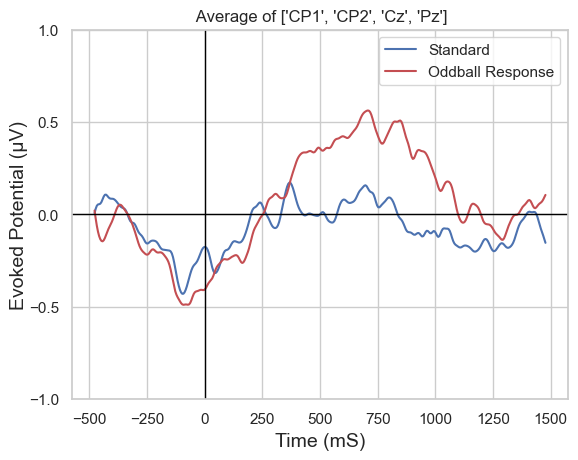

<Figure size 640x480 with 0 Axes>

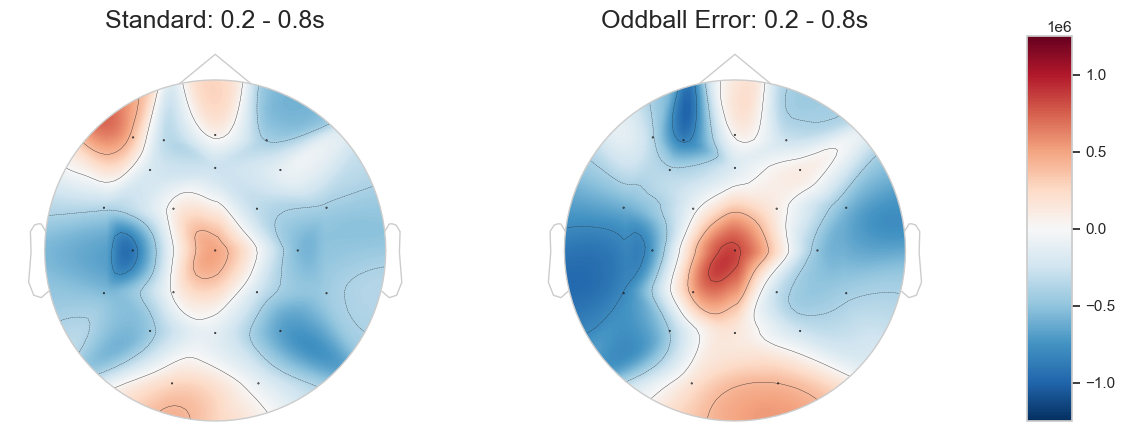

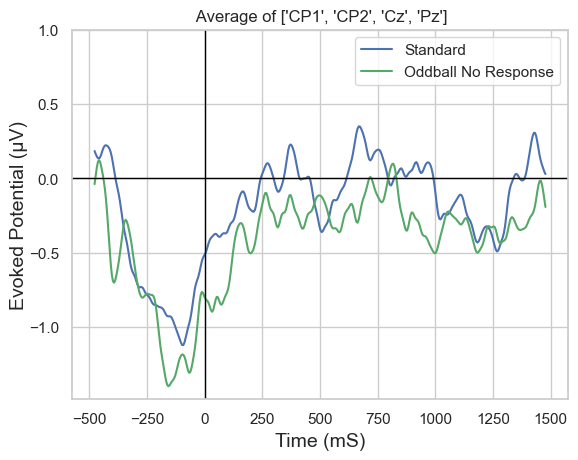

<Figure size 640x480 with 0 Axes>

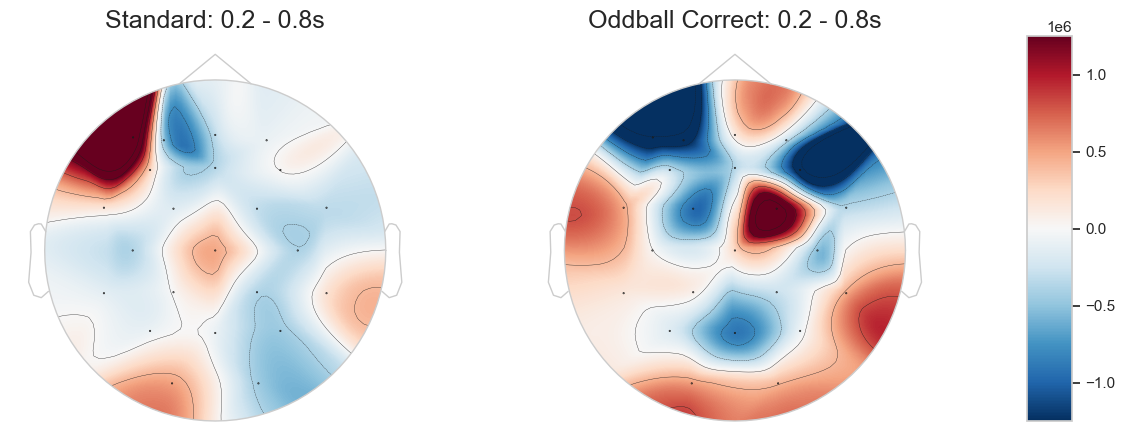

In [74]:
resp = {'007':0,'008':1,'011':2,'013':3}
non_resp = {'008':1,'011':2,'013':3,'014':4,'015':5}
event_id = dict( Standard=1,Oddball=101)
ch_picks = ['AF7',  'AF4', 'AFz', 'AF3', 'F4', 'Fz', 'F3', 'FC6', 'FC2', 'FC1', 'FC5',
            'C4', 'Cz', 'C3', 'CP6', 'CP2', 'CP1', 'CP5', 'Pz','P4', 'P3', 'O2', 'O1']

ERP = 'Pe'
avg=True

if avg==True and ERP == 'ERN':
    elec = ['Fz','Cz','FC1','FC2']
    t_center = 0.015
    t_width = 0.070
elif avg==True and ERP == 'Pe':    
    elec = ['CP1','CP2','Cz','Pz']
    t_center = 0.5
    t_width = 0.6
elif avg==False and ERP == 'ERN':
    elec = ['Cz']
    t_center = 0.015
    t_width = 0.070
elif avg==False and ERP == 'Pe':    
    elec = ['Cz']
    t_center = 0.5
    t_width = 0.6
    
crop_min,crop_max = -0.5,1.5
task_res = ['Responders', 'Non Responders']


for ires, res in enumerate(task_res):
    if res == 'Responders':
        resp_idx = list(resp.values())
    else:
        resp_idx = list(non_resp.values())
    evoked_odd_all=[]
    evoked_odd_NE_all=[]
    evoked_typ_all=[]
    evoked_typ_NE_all=[]

    evoked_odd_all_Cz = []
    evoked_odd_NE_all_Cz = [] 
    evoked_typ_all_Cz=[]
    evoked_typ_NE_all_Cz=[]
        
    epoch_odd_all_Cz=[]
    epoch_odd_NE_all_Cz=[]
    epoch_typ_all_Cz=[]
    epoch_typ_NE_all_Cz=[]   
   
    
    for i in resp_idx:
        if avg==True:
            evoked_odd_all_Cz.append(epochs_aff_odd_all_filt[i].copy().crop(crop_min,crop_max).pick(elec).average().get_data().mean(axis=0))
            evoked_odd_NE_all_Cz.append(epochs_aff_odd_NE_all_filt[i].copy().crop(crop_min,crop_max).pick(elec).average().get_data().mean(axis=0))
            evoked_typ_all_Cz.append(epochs_aff_typ_all_filt[i].copy().crop(crop_min,crop_max).pick(elec).average().get_data().mean(axis=0))
            evoked_typ_NE_all_Cz.append(epochs_aff_typ_NE_all_filt[i].copy().crop(crop_min,crop_max).pick(elec).average().get_data().mean(axis=0))

            epoch_odd_all_Cz.append(epochs_aff_odd_all_filt[i].copy().crop(crop_min,crop_max).pick(elec).get_data())
            epoch_odd_NE_all_Cz.append(epochs_aff_odd_NE_all_filt[i].copy().crop(crop_min,crop_max).pick(elec).get_data())
            epoch_typ_all_Cz.append(epochs_aff_typ_all_filt[i].copy().crop(crop_min,crop_max).pick(elec).get_data())
            epoch_typ_NE_all_Cz.append(epochs_aff_typ_NE_all_filt[i].copy().crop(crop_min,crop_max).pick(elec).get_data())
                       
        else:
            evoked_odd_all_Cz.append(epochs_aff_odd_all_filt[i].copy().crop(crop_min,crop_max).pick(elec).average().get_data()[0])
            evoked_odd_NE_all_Cz.append(epochs_aff_odd_NE_all_filt[i].copy().crop(crop_min,crop_max).pick(elec).average().get_data().mean(axis=0))
            evoked_typ_all_Cz.append(epochs_aff_typ_all_filt[i].copy().crop(crop_min,crop_max).pick(elec).average().get_data()[0])
            evoked_typ_NE_all_Cz.append(epochs_aff_typ_NE_all_filt[i].copy().crop(crop_min,crop_max).pick(elec).average().get_data().mean(axis=0))

        evoked_odd_all.append(epochs_aff_odd_all_filt[i].copy().pick(ch_picks).average().get_data())
        evoked_odd_NE_all.append(epochs_aff_odd_NE_all_filt[i].copy().pick(ch_picks).average().get_data())
        evoked_typ_all.append(epochs_aff_typ_all_filt[i].copy().pick(ch_picks).average().get_data())
        evoked_typ_NE_all.append(epochs_aff_typ_NE_all_filt[i].copy().pick(ch_picks).average().get_data())

    evoked_odd_all=np.array(evoked_odd_all)
    evoked_odd_NE_all=np.array(evoked_odd_NE_all)
    evoked_typ_all_Cz=np.array(evoked_typ_all_Cz)
    evoked_typ_NE_all_Cz=np.array(evoked_typ_NE_all_Cz)    


    #epoch_odd_all_Cz=np.array(epoch_odd_all_Cz)
    #epoch_odd_NE_all_Cz=np.array(epoch_odd_NE_all_Cz)
    #epoch_typ_all_Cz=np.array(epoch_typ_all_Cz)
    #epoch_typ_NE_all_Cz=np.array(epoch_typ_NE_all_Cz)
   
    
    evoked_odd_avg_data = evoked_odd_all.mean(axis=0)
    evoked_odd_NE_avg_data = evoked_odd_NE_all.mean(axis=0)
        
    evoked_typ_all=np.array(evoked_typ_all)
    evoked_typ_NE_all=np.array(evoked_typ_NE_all)
    
    evoked_odd_all_Cz=np.array(evoked_odd_all_Cz)
    evoked_odd_NE_all_Cz=np.array(evoked_odd_NE_all_Cz)

    evoked_typ_avg_data = evoked_typ_all.mean(axis=0)
    evoked_typ_NE_avg_data = evoked_typ_NE_all.mean(axis=0)
    
    if res == 'Responders':
        X1_evk_odd_E=np.array(evoked_odd_all_Cz)
        X1_evk_odd_NE=np.array(evoked_odd_NE_all_Cz)
        X2_evk_typ_E=np.array(evoked_typ_all_Cz)
        X2_evk_typ_NE=np.array(evoked_typ_NE_all_Cz) 
    else:
        X3_evk_odd_E=np.array(evoked_odd_all_Cz)
        X3_evk_odd_NE=np.array(evoked_odd_NE_all_Cz)
        X4_evk_typ_E=np.array(evoked_typ_all_Cz)
        X4_evk_typ_NE=np.array(evoked_typ_NE_all_Cz)   
    
    evoked_odd_avg = mne.EvokedArray(evoked_odd_avg_data, epochs_aff_odd_all_filt[i].copy().pick(ch_picks).info, tmin = epochs_aff_odd_all_filt[i].copy().pick(ch_picks).tmin, kind='average', baseline=None, verbose=None)
    evoked_odd_NE_avg = mne.EvokedArray(evoked_odd_NE_avg_data, epochs_aff_odd_NE_all_filt[i].copy().pick(ch_picks).info, tmin = epochs_aff_odd_NE_all_filt[i].copy().pick(ch_picks).tmin, kind='average', baseline=None, verbose=None)
    evoked_typ_avg = mne.EvokedArray(evoked_typ_avg_data, epochs_aff_typ_all_filt[i].copy().pick(ch_picks).info, tmin = epochs_aff_typ_all_filt[i].copy().pick(ch_picks).tmin, kind='average', baseline=None, verbose=None)
    evoked_typ_NE_avg = mne.EvokedArray(evoked_typ_NE_avg_data, epochs_aff_typ_NE_all_filt[i].copy().pick(ch_picks).info, tmin = epochs_aff_typ_NE_all_filt[i].copy().pick(ch_picks).tmin, kind='average', baseline=None, verbose=None)
        
    #evoked_typ_avg.copy().crop(crop_min,crop_max).plot_joint()
    #evoked_odd_avg.copy().crop(crop_min,crop_max).plot_joint()
    w=10
    time = evoked_typ_avg.copy().crop(crop_min,crop_max).times*1000
    time = moving_average(time, w)

    mean_odd_ERP = moving_average(evoked_odd_all_Cz.mean(axis=0),w)
    mean_odd_NE_ERP = moving_average(evoked_odd_NE_all_Cz.mean(axis=0),w)
    mean_typ_ERP = moving_average(evoked_typ_all_Cz.mean(axis=0),w)
    mean_typ_NE_ERP = moving_average(evoked_typ_NE_all_Cz.mean(axis=0),w)
    
    var_odd_ERP = moving_average(sem(evoked_odd_all_Cz,axis=0),w)
    var_odd_NE_ERP = moving_average(sem(evoked_odd_NE_all_Cz,axis=0),w)
    var_typ_ERP = moving_average(sem(evoked_typ_all_Cz,axis=0),w)
    var_typ_NE_ERP = moving_average(sem(evoked_typ_NE_all_Cz,axis=0),w)
    
    
    plt.figure(1)
    
    
    if res== 'Responders':
        plt.plot(time,mean_typ_ERP,color='b')
        plt.plot(time,mean_odd_ERP,color='r')
        #plt.fill_between(time,mean_odd+var_odd, mean_odd-var_odd,alpha=0.2,color='r')
        #plt.fill_between(time,mean_typ+var_typ, mean_typ-var_typ,alpha=0.2,color='b')
        plt.legend(['Standard','Oddball Response'])

    elif res== 'Non Responders':
        plt.plot(time,mean_typ_NE_ERP,color='b')
        plt.plot(time,mean_odd_NE_ERP,color='g')
        #plt.fill_between(time,mean_odd_NE+var_odd_NE, mean_odd_NE-var_odd_NE,alpha=0.2,color='g')
        #plt.fill_between(time,mean_typ_NE+var_typ_NE, mean_typ_NE-var_typ_NE,alpha=0.2,color='b')
        plt.legend(['Standard','Oddball No Response'])
    

    plt.axvline(0, linewidth=1, color="black")
    plt.axhline(0, linewidth=1, color="black")
    

    if avg==True:
        plt.title(f' Average of {elec}')
    else:
        plt.title(f'{res} : {elec}')
    plt.xlabel('Time (mS)',fontsize = 14)
    plt.ylabel('Evoked Potential (µV)',fontsize = 14,labelpad=0.5) 
    plt.yticks(np.arange(-1,1.1,0.5))
    if res == 'Responderss':
        plt.fill_betweenx(range(-2,2), 0.5,1,color='gray', alpha=0.5)
        
    plt.show()    
    plt.figure(2)
    
    width_ratios=[10,10,1]
        
    fig,ax = plt.subplots(1,3,figsize=(14,5), gridspec_kw={"width_ratios": width_ratios})
    vmin,vamx = -1.25e6,1.25e6
    
    
    if res== 'Responders':
        evoked_typ_avg.plot_topomap(times=t_center, average=t_width, vlim=(vmin,vamx),axes=ax[0],colorbar=False,show=False)
        ax[0].set_title(f'Standard: {round(t_center-t_width/2,2)} - {round(t_center+t_width/2,2)}s',fontsize = 18)
        evoked_odd_avg.plot_topomap(times=t_center, average=t_width, vlim=(vmin,vamx),axes=ax[1],colorbar=False,show=False)
        ax[1].set_title(f'Oddball Error: {round(t_center-t_width/2,2)} - {round(t_center+t_width/2,2)}s',fontsize = 18)
        
    elif res== 'Non Responders':
        evoked_typ_NE_avg.plot_topomap(times=t_center, average=t_width, vlim=(vmin,vamx),axes=ax[0],colorbar=False,show=False)
        ax[0].set_title(f'Standard: {round(t_center-t_width/2,2)} - {round(t_center+t_width/2,2)}s',fontsize = 18)
        evoked_odd_NE_avg.plot_topomap(times=t_center, average=t_width, vlim=(vmin,vamx),axes=ax[1],colorbar=False,show=False)
        ax[1].set_title(f'Oddball Correct: {round(t_center-t_width/2,2)} - {round(t_center+t_width/2,2)}s',fontsize = 18)
    #fig.suptitle(f'{res}',fontsize = 24)
    fig.colorbar(ax[0].images[-1], cax=ax[-1]).ax.set_yscale("linear")

    ch_picks_plot =['Fz','Cz','Pz']



Include Behavior Figures 

Adding metadata with 9 columns
404 matching events found
No baseline correction applied
Dropped 0 epochs: 
Dropped 99 epochs: 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146


C:\Users\malann\AppData\Local\Temp\ipykernel_490492\1539721887.py:76: RuntimeWarning: The unit for channel(s) FP1 has changed from NA to V.
  epochs_aff_odd.set_channel_types(dict_eog)
C:\Users\malann\AppData\Local\Temp\ipykernel_490492\1539721887.py:77: RuntimeWarning: The unit for channel(s) FP1 has changed from NA to V.
  epochs_aff_typ.set_channel_types(dict_eog)


Dropped 0 epochs: 
Dropped 4 epochs: 44, 45, 46, 47
Dropped 0 epochs: 
Dropped 44 epochs: 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47
Adding metadata with 9 columns
431 matching events found
No baseline correction applied
Dropped 0 epochs: 
Dropped 103 epochs: 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152


C:\Users\malann\AppData\Local\Temp\ipykernel_490492\1539721887.py:76: RuntimeWarning: The unit for channel(s) FP1 has changed from NA to V.
  epochs_aff_odd.set_channel_types(dict_eog)
C:\Users\malann\AppData\Local\Temp\ipykernel_490492\1539721887.py:77: RuntimeWarning: The unit for channel(s) FP1 has changed from NA to V.
  epochs_aff_typ.set_channel_types(dict_eog)


Dropped 0 epochs: 
Dropped 2 epochs: 48, 49
Dropped 0 epochs: 
Dropped 48 epochs: 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49
Adding metadata with 9 columns
600 matching events found
No baseline correction applied
Dropped 0 epochs: 
Dropped 144 epochs: 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 

C:\Users\malann\AppData\Local\Temp\ipykernel_490492\1539721887.py:76: RuntimeWarning: The unit for channel(s) FP1 has changed from NA to V.
  epochs_aff_odd.set_channel_types(dict_eog)
C:\Users\malann\AppData\Local\Temp\ipykernel_490492\1539721887.py:77: RuntimeWarning: The unit for channel(s) FP1 has changed from NA to V.
  epochs_aff_typ.set_channel_types(dict_eog)


Dropped 0 epochs: 
Dropped 28 epochs: 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77
Dropped 0 epochs: 
Dropped 50 epochs: 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77
Adding metadata with 9 columns
599 matching events found
No baseline correction applied
Dropped 0 epochs: 
Dropped 145 epochs: 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 

C:\Users\malann\AppData\Local\Temp\ipykernel_490492\1539721887.py:76: RuntimeWarning: The unit for channel(s) FP1 has changed from NA to V.
  epochs_aff_odd.set_channel_types(dict_eog)
C:\Users\malann\AppData\Local\Temp\ipykernel_490492\1539721887.py:77: RuntimeWarning: The unit for channel(s) FP1 has changed from NA to V.
  epochs_aff_typ.set_channel_types(dict_eog)


Dropped 0 epochs: 
Dropped 29 epochs: 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76
Dropped 0 epochs: 
Dropped 48 epochs: 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76
Adding metadata with 9 columns
494 matching events found
No baseline correction applied
Dropped 0 epochs: 
Dropped 117 epochs: 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 16

C:\Users\malann\AppData\Local\Temp\ipykernel_490492\1539721887.py:76: RuntimeWarning: The unit for channel(s) FP1 has changed from NA to V.
  epochs_aff_odd.set_channel_types(dict_eog)
C:\Users\malann\AppData\Local\Temp\ipykernel_490492\1539721887.py:77: RuntimeWarning: The unit for channel(s) FP1 has changed from NA to V.
  epochs_aff_typ.set_channel_types(dict_eog)


Dropped 0 epochs: 
Dropped 60 epochs: 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63
Dropped 0 epochs: 
Dropped 4 epochs: 60, 61, 62, 63
Adding metadata with 9 columns
445 matching events found
No baseline correction applied
Dropped 0 epochs: 
Dropped 92 epochs: 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143


C:\Users\malann\AppData\Local\Temp\ipykernel_490492\1539721887.py:76: RuntimeWarning: The unit for channel(s) FP1 has changed from NA to V.
  epochs_aff_odd.set_channel_types(dict_eog)
C:\Users\malann\AppData\Local\Temp\ipykernel_490492\1539721887.py:77: RuntimeWarning: The unit for channel(s) FP1 has changed from NA to V.
  epochs_aff_typ.set_channel_types(dict_eog)


Dropped 0 epochs: 
Dropped 42 epochs: 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51
Dropped 0 epochs: 
Dropped 10 epochs: 42, 43, 44, 45, 46, 47, 48, 49, 50, 51


<Figure size 640x480 with 0 Axes>

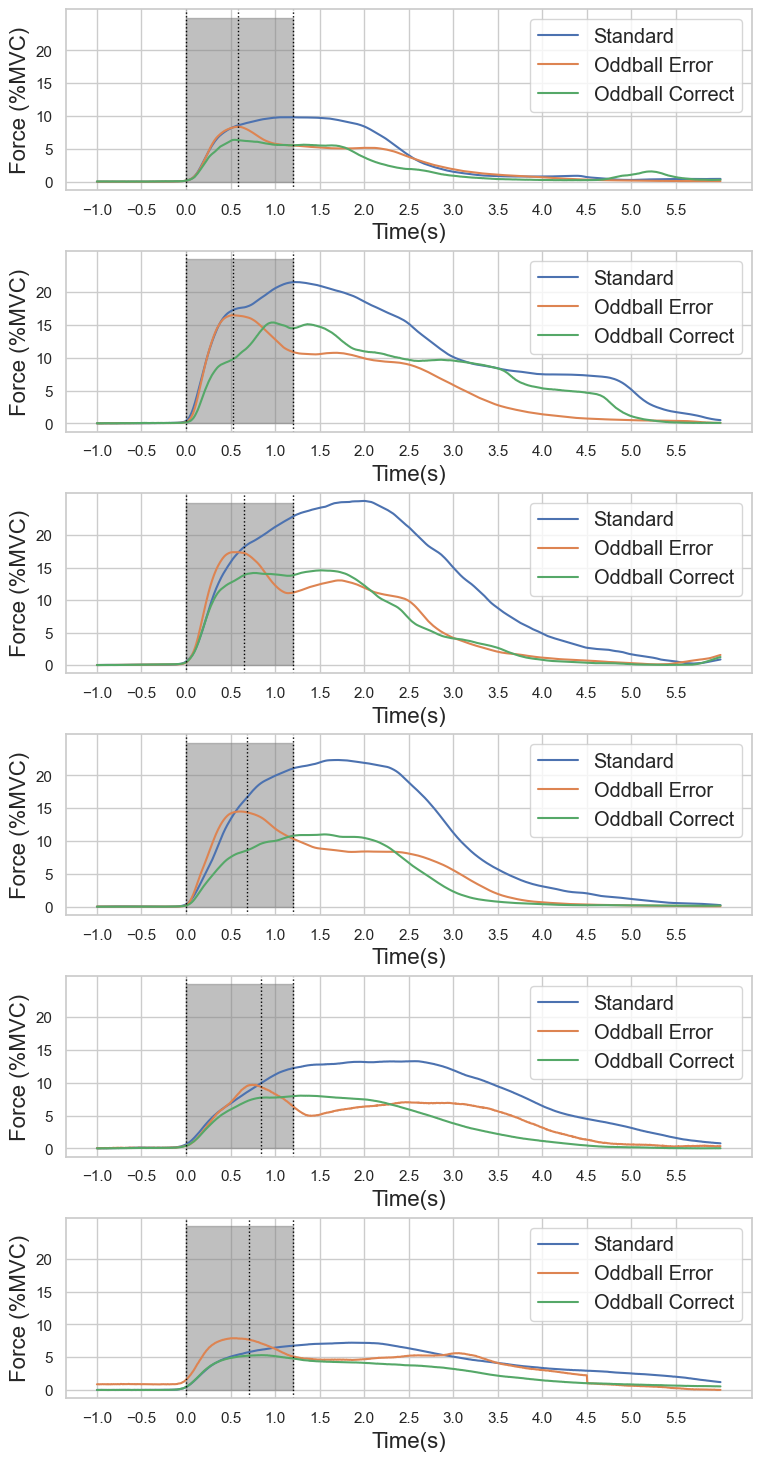

In [75]:
base_dir = "E:/Oddball Data/"
subj_list = ['007','008','011','013','014','015']
#subj_list = ['007']

stage = ['implant']#, 'implant']explant
aff_cond = ['1', '101'];
aff_cond_plot = ['Standard', 'Oddball'];

naff_cond = ['10', '110'];

hand = 'aff'

if hand == 'naff':
    aff_cond = naff_cond
    
#fig, ax1 = plt.subplots(figsize=(4.5, 10.5), nrows=3, ncols=2, layout="constrained")

for axi, st in enumerate(stage):
    ERR_value_all = []
    ERR_E_value_all = []
    ERR_NE_value_all = []
    slope_value_all = []
    epochs_aff_typ_all = []
    epochs_aff_odd_all = []
    
    dyno_typ_all = []
    dyno_odd_all = []
    dyno_odd_E_all =[]
    dyno_odd_NE_all = []
    
    outlier_idx_all = []
    outlier_idx_odd_no_err_all = []
    
    plt.figure()
    fig, axes = plt.subplots(figsize=(7.5, 14.5), nrows=6, ncols=1, layout="constrained")

    for ax, sub in zip(axes, subj_list):
        data_dir = base_dir+"EDEN"+sub+'/ANALYSIS/'
        
        if hand == 'naff':
            fname = data_dir+"data_clean"+st+'_naff_cond.mat'
            dyno = 'DynR(lc)'
        else:
            fname = data_dir+"data_clean"+st+'.mat'
            dyno = 'DynL(lc)'        
                
        if sub == '015' or sub=='014':
            dict1 = dict015
        elif sub == '013' and st== 'implant':
            dict1 = dict013_imp
        elif sub == '013' and st== 'explant':
            dict1 = dict013_exp
        elif sub == '011' and st== 'implant':
            dict1 = dict011_imp
        elif sub == '011' and st== 'explant':
            dict1 = dict011_exp
        elif sub == '008' and st== 'implant':
            dict1 = dict08_imp
        elif sub == '008' and st== 'explant':
            dict1 = dict08_exp
        elif sub == '007' and st== 'implant':
            dict1 = dict07_imp
        elif sub == '007' and st== 'explant':
            dict1 = dict07_exp

        info = mne.create_info(list(dict1.keys()), sfreq=200, ch_types='misc', verbose=None)
        epochs = mne.read_epochs_fieldtrip(fname,info,data_name='x', trialinfo_column=0)
        
        sfreq = epochs.info['sfreq']

        epochs_aff_odd = epochs[aff_cond[1]]
        epochs_aff_typ = epochs[aff_cond[0]]

        mne.epochs.equalize_epoch_counts([epochs_aff_odd,epochs_aff_typ], method='truncate')
        
        epochs_aff_odd.set_channel_types(dict_eog)
        epochs_aff_typ.set_channel_types(dict_eog)
        
                
        epochs_aff_typ_E = epochs_aff_typ.copy()
        epochs_aff_typ_NE = epochs_aff_typ.copy()
        
        # calculate outlier trial
        tmax = 6
        Dynmo_odd = epochs_aff_odd.copy().crop(-1,tmax).get_data(picks=dyno)
        Dynmo_odd = Dynmo_odd.reshape(Dynmo_odd.shape[0],Dynmo_odd.shape[2])
                       
        t_target = int(200+200*1.5)
        #Calculate Error Rate
        ERR_value = []
        for i in range(len(Dynmo_odd)):
            ERR_value1 = ((Dynmo_odd[i,:].max()-Dynmo_odd[i,t_target])*100)/Dynmo_odd[i,t_target]
            ERR_value.append(ERR_value1)
        ERR_value_all.append(ERR_value)

        #Calculate Slope
        slope_value = []
        for i in range(len(Dynmo_odd)): 
            f_max_time_trail = np.argmax(epochs_aff_odd.copy().crop(0,1).get_data(picks=dyno).reshape(epochs_aff_odd.copy().crop(0,1).get_data(picks=dyno).shape[0],epochs_aff_odd.copy().crop(0,1).get_data(picks=dyno).shape[2])[i])/200
            slope_value1 = 1/f_max_time_trail
            slope_value.append(slope_value1)
        slope_value_all.append(slope_value)    
        
        over_thres = 20
        
        outlier_idx=[]
        outlier_idx_odd_no_err=[]
        for j,m in enumerate(ERR_value):
            if (m>over_thres):
                outlier_idx.append(j)
            else:
                outlier_idx_odd_no_err.append(j)

        outlier_idx_all.append(outlier_idx)
        outlier_idx_odd_no_err_all.append(outlier_idx_odd_no_err)
        
        
        epochs_aff_odd_E=epochs_aff_odd[outlier_idx]
        epochs_aff_odd_NE=epochs_aff_odd[outlier_idx_odd_no_err]
        
        mne.epochs.equalize_epoch_counts([epochs_aff_odd_E,epochs_aff_typ_E], method='truncate')
        mne.epochs.equalize_epoch_counts([epochs_aff_odd_NE,epochs_aff_typ_NE], method='truncate')
       
        
        # redefine Dynmo channel into oddball error and oddball correct
        Dynmo_odd = epochs_aff_odd.copy().crop(-1,tmax).get_data(picks=dyno)
        Dynmo_odd = Dynmo_odd.reshape(Dynmo_odd.shape[0],Dynmo_odd.shape[2])        
        Dynmo_odd_E = epochs_aff_odd_E.copy().crop(-1,tmax).get_data(picks=dyno)
        Dynmo_odd_E = Dynmo_odd_E.reshape(Dynmo_odd_E.shape[0],Dynmo_odd_E.shape[2])
        Dynmo_odd_NE = epochs_aff_odd_NE.copy().crop(-1,tmax).get_data(picks=dyno)
        Dynmo_odd_NE = Dynmo_odd_NE.reshape(Dynmo_odd_NE.shape[0],Dynmo_odd_NE.shape[2])  
                
        
        #Calculate overshoot for error and correct
        ERR_NE_value = []
        for i in range(len(Dynmo_odd_NE)):
            ERR_NE_value1 = ((Dynmo_odd_NE[i,:].max()-Dynmo_odd_NE[i,t_target])*100)/Dynmo_odd_NE[i,t_target]
            ERR_NE_value.append(ERR_NE_value1)
        ERR_NE_value_all.append(ERR_NE_value)
        
        ERR_E_value = []
        for i in range(len(Dynmo_odd_E)):
            ERR_E_value1 = ((Dynmo_odd_E[i,:].max()-Dynmo_odd_E[i,t_target])*100)/Dynmo_odd_E[i,t_target]
            ERR_E_value.append(ERR_E_value1)
        ERR_E_value_all.append(ERR_E_value)                       

        Dynmo_odd= Dynmo_odd.mean(axis=0)
        Dynmo_odd = Dynmo_odd-Dynmo_odd_E.min()        
        Dynmo_odd_E= Dynmo_odd_E.mean(axis=0)
        Dynmo_odd_E = Dynmo_odd_E-Dynmo_odd_E.min()
        Dynmo_odd_NE= Dynmo_odd_NE.mean(axis=0)
        Dynmo_odd_NE = Dynmo_odd_NE-Dynmo_odd_NE.min()        
        
        Dynmo_typ = epochs_aff_typ.copy().crop(-1,tmax).get_data(picks=dyno)
        Dynmo_typ= Dynmo_typ.reshape(Dynmo_typ.shape[0],Dynmo_typ.shape[2]).mean(axis=0)
        Dynmo_typ = Dynmo_typ-Dynmo_typ.min()
        f_max_time = np.argmax(epochs_aff_odd.copy().crop(0,1).get_data(picks=dyno).reshape(epochs_aff_odd.copy().crop(0,1).get_data(picks=dyno).shape[0],epochs_aff_odd.copy().crop(0,1).get_data(picks=dyno).shape[2]).mean(axis=0))/200

        time_force= epochs_aff_typ.copy().crop(-1,tmax).times
        
        dyno_typ_all.append(Dynmo_typ*100)
        dyno_odd_all.append(Dynmo_odd*100)
        dyno_odd_E_all.append(Dynmo_odd_E*100)
        dyno_odd_NE_all.append(Dynmo_odd_NE*100)
        
        ax.plot(epochs_aff_typ.copy().crop(-1,tmax).times,Dynmo_typ*100)
        ax.plot(epochs_aff_odd_E.copy().crop(-1,tmax).times,Dynmo_odd_E*100)
        ax.plot(epochs_aff_odd_NE.copy().crop(-1,tmax).times,Dynmo_odd_NE*100)

        x=np.arange(-1,tmax,0.2)

        ax.set_xticks(x)
        idx = np.argwhere(np.diff(np.sign(Dynmo_typ - Dynmo_odd_E))).flatten()

        ax.axvline(0, linewidth=1, color="black", linestyle=":")

        ax.axvline(f_max_time, linewidth=1, color="black", linestyle=":")
        ax.axvline(1.2, linewidth=1, color="black", linestyle=":")
        ax.fill_betweenx(np.array((0,25)), 1.2,0,color='gray', alpha=0.5)

        ax.legend(['Standard','Oddball Error', 'Oddball Correct'],fontsize ='large')
        ax.set_xlabel('Time(s)',fontsize=16)
        ax.set_ylabel('Force (%MVC)',fontsize=16)
        ax.set_yticks(np.arange(0,25,5))
        ax.set_xticks(np.arange(-1,tmax,0.5))

   #Correlation between slope and Error rate
    
    ERR_mean_all = []
    ERR_E_mean_all = []
    ERR_NE_mean_all = []
    
    for i,(n,e,ne) in enumerate(zip(ERR_value_all,ERR_E_value_all,ERR_NE_value_all)):
        ERR_mean_all.append(np.array(n).mean())
        ERR_E_mean_all.append(np.array(e).mean())
        ERR_NE_mean_all.append(np.array(ne).mean())
        
    slope_mean_all = [] 
    for i,n in enumerate(slope_value_all):
        slope_mean_all.append(np.array(n).mean())
          
    if st=='implant':
        
        ERR_all_implant = ERR_value_all
        ERR_E_all_implant = ERR_E_value_all
        ERR_NE_all_implant = ERR_NE_value_all
                
        ERR_mean_all_implant = ERR_mean_all
        ERR_E_mean_all_implant = ERR_E_mean_all
        ERR_NE_mean_all_implant = ERR_NE_mean_all        
        
        slope_mean_all_implant = slope_mean_all
        slope_all_implant = slope_value_all
    else:
        ERR_all_explant = ERR_value_all
        ERR_E_all_explant = ERR_E_value_all
        ERR_NE_all_explant = ERR_NE_value_all
        
        ERR_mean_all_explant = ERR_mean_all
        ERR_E_mean_all_explant = ERR_E_mean_all
        ERR_NE_mean_all_explant = ERR_NE_mean_all    
        
        slope_mean_all_explant = slope_mean_all
        slope_all_explant = slope_value_all




# Compute the means and standard errors
dyno_typ_all = np.array(dyno_typ_all)
dyno_odd_E_all = np.array(dyno_odd_E_all)
dyno_odd_NE_all = np.array(dyno_odd_NE_all)

mean_typ = dyno_typ_all.mean(axis=0)
mean_odd_E = dyno_odd_E_all.mean(axis=0)
mean_odd_NE = dyno_odd_NE_all.mean(axis=0)

var_typ = sem(dyno_typ_all, axis=0)
var_odd_E = sem(dyno_odd_E_all, axis=0)
var_odd_NE = sem(dyno_odd_NE_all, axis=0)

# Select specific data slices
dyno_typ_all1 = dyno_typ_all[0:4, 100:601]
dyno_odd_E_all1 = dyno_odd_E_all[0:4, 100:601]
dyno_odd_NE_all1 = dyno_odd_NE_all[2:6, 100:601]

mean_typ1 = dyno_typ_all1.mean(axis=0)
mean_odd_E1 = dyno_odd_E_all1.mean(axis=0)
mean_odd_NE1 = dyno_odd_NE_all1.mean(axis=0)

var_typ1 = sem(dyno_typ_all1, axis=0)
var_odd_E1 = sem(dyno_odd_E_all1, axis=0)
var_odd_NE1 = sem(dyno_odd_NE_all1, axis=0)

time1 = time_force[100:601]


# Error Rate correction
slope_value_all_corr = []
ERR_value_all_corr = []
ERR_E_value_all_corr = []
ERR_NE_value_all_corr = []

outlier_idx = []
res_list = [0,1,2]

Res_ERR = []
Nres_ERR = []
Res_slope = []
Nres_slope = []

for i,(n,e,ne,nn) in enumerate(zip(ERR_value_all,ERR_E_value_all,ERR_NE_value_all, slope_value_all)):
    ERR_value_all_corr1 = []
    ERR_E_value_all_corr1 = []
    ERR_NE_value_all_corr1 = []
    slope_value_all_corr1 = []
    outlier_idx1=[]
    
    
    for j,m in enumerate(n):
        if (m<100) : # and (m<np.array(n).mean()+3*np.std(np.array(n))) and (m>np.array(n).mean()-3*np.std(np.array(n)))
   
            outlier_idx1.append(j)
            ERR_value_all_corr1.append(m)
            
            if i in res_list:
                Res_ERR.append(m)
            else:
                Nres_ERR.append(m)
                
    for j1, me in enumerate(e):
        
        if (me<100): # and (me<np.array(e).mean()+3*np.std(np.array(e))) and (me>np.array(e).mean()-3*np.std(np.array(e))):
            ERR_E_value_all_corr1.append(me)    
    
    for j2, mne1 in enumerate(ne):
                        
        if (mne1<20):
            ERR_NE_value_all_corr1.append(mne1)
            
    for j3, mm in enumerate(nn):

        if (mm<np.array(nn).mean()+5*sem(np.array(nn))) and (mm>np.array(nn).mean()-5*sem(np.array(nn))):
            slope_value_all_corr1.append(mm)


            
    ERR_value_all_corr.append(ERR_value_all_corr1)
    ERR_E_value_all_corr.append(ERR_E_value_all_corr1)
    ERR_NE_value_all_corr.append(ERR_NE_value_all_corr1)
    
    slope_value_all_corr.append(slope_value_all_corr1)
    outlier_idx.append(outlier_idx1)

N_Res_ERR = [Res_ERR,Nres_ERR]
N_Res_slope = [Res_slope,Nres_slope]


if st=='implant':
    ERR_value_all_corr = ERR_value_all_corr
    ERR_mean_all = ERR_mean_all_implant
    slope_mean_all = slope_mean_all_implant
    slope_value_all_corr = slope_value_all_corr
else:        
    ERR_value_all_corr = ERR_all_explant
    ERR_mean_all = ERR_mean_all_explant 
    slope_mean_all = slope_mean_all_explant
    slope_value_all_corr = slope_all_explant     

In [77]:
time_force.shape

(1401,)

C:\Users\malann\AppData\Local\Temp\ipykernel_490492\2778071694.py:153: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leave space on the right for the plot but not the legend
C:\Users\malann\AppData\Local\Temp\ipykernel_490492\2778071694.py:156: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


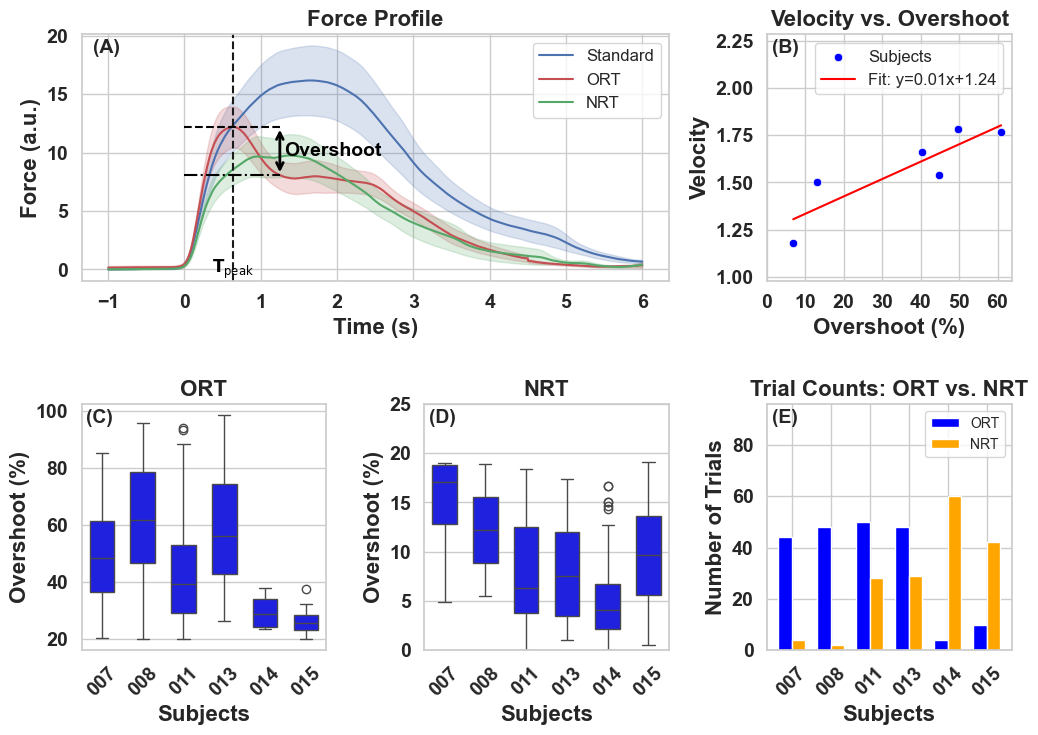

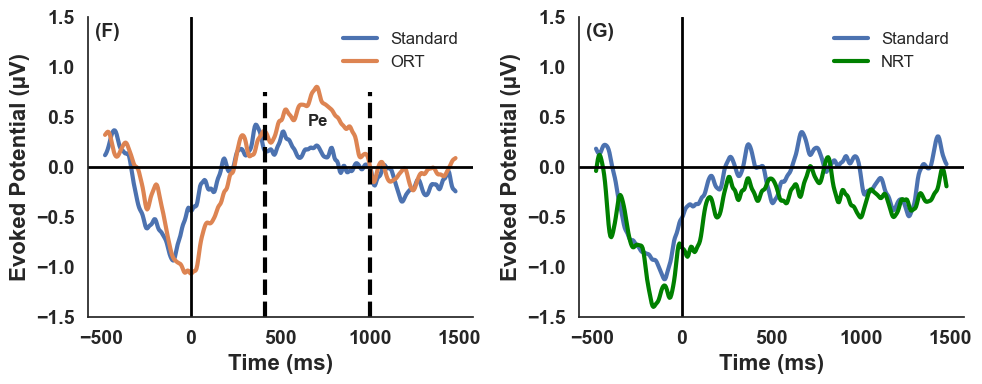

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import rcParams

# Set global font size and font family
rcParams['font.family'] = 'Arial'  # You can change this to 'Times New Roman' or another font
rcParams['font.size'] = 14  # Base font size for text elements

# Set Seaborn theme
sns.set_theme(style="whitegrid")

# Assume time, mean_typ, mean_odd_E, mean_odd_NE, var_typ, var_odd_E, var_odd_NE, and subj_list are already defined

# Find the peak time for ORT (mean_odd_E)
peak_time_ORT = time_force[np.argmax(mean_odd_E)]

# Find the value of ORT at 1.25s
value_at_1_25s = np.interp(1.25, time_force, mean_odd_E)  # Interpolate to find the value at 1.25s

# Create a figure with adjusted width
fig = plt.figure(figsize=(12, 8))
grid = plt.GridSpec(2, 3, wspace=0.4, hspace=0.5)  # Adjusted wspace, hspace for spacing


# Force profile
ax1 = fig.add_subplot(grid[0, :2])
ax1.plot(time_force, mean_typ, color='b', label='Standard')
ax1.plot(time_force, mean_odd_E, color='r', label='ORT')
ax1.plot(time_force, mean_odd_NE, color='g', label='NRT')
ax1.fill_between(time_force, mean_typ + var_typ, mean_typ - var_typ, alpha=0.2, color='b')
ax1.fill_between(time_force, mean_odd_E + var_odd_E, mean_odd_E - var_odd_E, alpha=0.2, color='r')
ax1.fill_between(time_force, mean_odd_NE + var_odd_NE, mean_odd_NE - var_odd_NE, alpha=0.2, color='g')
ax1.set_xlabel('Time (s)', fontsize=16, fontweight='bold')
ax1.set_ylabel('Force (a.u.)', fontsize=16, fontweight='bold')
ax1.set_title('Force Profile', fontsize=16, fontweight='bold')

# Add a dashed vertical line at the peak of ORT
ax1.axvline(x=peak_time_ORT, color='k', linestyle='--', label=f'Peak Time = {peak_time_ORT:.2f}s')

# Add a horizontal line from 0 to 1.25s at the ORT peak value
ax1.hlines(y=mean_odd_E[np.argmax(mean_odd_E)], xmin=0, xmax=1.25, color='black', linestyle='--', label=f'Peak to 1.25s')

# Add a horizontal line at ORT value at 1.25s
ax1.hlines(y=value_at_1_25s, xmin=0, xmax=1.25, color='black', linestyle='-.', label=f'Value at 1.25s = {value_at_1_25s:.2f}%')

# Add a vertical line between the two horizontal lines with arrows on both sides
ax1.annotate('', xy=(1.25, mean_odd_E[np.argmax(mean_odd_E)]), xytext=(1.25, value_at_1_25s),
             arrowprops=dict(facecolor='black', edgecolor='black', arrowstyle='<->', lw=2))

# Add a label for "Overshoot"
ax1.text(1.3, (mean_odd_E[np.argmax(mean_odd_E)] + value_at_1_25s) / 2,
         'Overshoot', color='black', fontsize=14, fontweight='bold', va='center', ha='left')

# Add figure number (A) inside the plot at the left-most corner
ax1.text(0.02, 0.98, '(A)', transform=ax1.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# Legend with reduced font size
ax1.legend(['Standard', 'ORT', 'NRT'], fontsize=12, title_fontsize=12, loc='upper right', title=None)

# Add T_peak (peak in subscript) close to the x-axis near the vertical line, and make it bold
ax1.text(peak_time_ORT, ax1.get_ylim()[0], r"$\mathbf{T_{\mathrm{peak}}}$", fontsize=12, fontweight='bold',
         ha='center', va='bottom', color='black')


# Correlation plot
ax2 = fig.add_subplot(grid[0, 2])
sns.scatterplot(x=ERR_mean_all, y=slope_mean_all, ax=ax2, color='blue', label='Data points')
m, b = np.polyfit(ERR_mean_all, slope_mean_all, 1)
sns.lineplot(x=ERR_mean_all, y=m * np.array(ERR_mean_all) + b, ax=ax2, color='red', label=f'Fit: y={m:.2f}x+{b:.2f}')
ax2.set_xlabel('Overshoot (%)', fontsize=16, fontweight='bold')
ax2.set_ylabel('Velocity', fontsize=16, fontweight='bold')
ax2.set_title('Velocity vs. Overshoot', fontsize=16, fontweight='bold')

# Adjust xticks range between 0 and 60
ax2.set_xticks(np.arange(0, 61, 10))  # Adjusting the range of x-axis between 0 and 60
ax2.set_ylim(bottom=min(slope_mean_all)-0.2, top=max(slope_mean_all) + 0.5)  # Adjust the limits by adding some padding

# Move the legend to the top-right corner
ax2.legend(['Subjects', f'Fit: y={m:.2f}x+{b:.2f}'], fontsize=12, title_fontsize=12, loc='upper right', title=None)

# Add figure number (B) inside the plot at the left-most corner
ax2.text(0.02, 0.98, '(B)', transform=ax2.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# Boxplot: Oddball Response
ax3 = fig.add_subplot(grid[1, 0])
sns.boxplot(data=ERR_E_value_all_corr, ax=ax3, color='blue', width=0.6)
ax3.set_title('ORT', fontsize=16, fontweight='bold')
ax3.set_xlabel('Subjects', fontsize=16, fontweight='bold')
ax3.set_ylabel('Overshoot (%)', fontsize=16, fontweight='bold')
ax3.set_xticks(range(len(subj_list)))
ax3.set_xticklabels(subj_list, rotation=45)

# Add figure number (C) inside the plot at the left-most corner
ax3.text(0.02, 0.98, '(C)', transform=ax3.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# Boxplot: Oddball No Response
ax4 = fig.add_subplot(grid[1, 1])
sns.boxplot(data=ERR_NE_value_all_corr, ax=ax4, color='blue', width=0.6)
ax4.set_title('NRT', fontsize=16, fontweight='bold')
ax4.set_xlabel('Subjects', fontsize=16, fontweight='bold')
ax4.set_ylabel('Overshoot (%)', fontsize=16, fontweight='bold')
ax4.set_xticks(range(len(subj_list)))
ax4.set_xticklabels(subj_list, rotation=45)

# Increase the y-axis limit for plot (D)
ax4.set_ylim(bottom=0, top=25)  # Increase y-limit

# Add figure number (D) inside the plot at the left-most corner
ax4.text(0.02, 0.98, '(D)', transform=ax4.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

len_out_E = []
len_out_NE = []

for iout, (out, out_NE) in enumerate(zip(outlier_idx_all ,outlier_idx_odd_no_err_all)):
    len_out_E.append(len(out))
    len_out_NE.append(len(out_NE))


# Bar chart: Number of Trials (Avoid overlap and adjust legend)
ax5 = fig.add_subplot(grid[1, 2])
X_axis = np.arange(len(subj_list))
bar_width = 0.35
ax5.bar(X_axis - bar_width / 2, len_out_E, bar_width, label='ORT', color='blue')
ax5.bar(X_axis + bar_width / 2, len_out_NE, bar_width, label='NRT', color='orange')
ax5.set_xticks(X_axis)
ax5.set_xticklabels(subj_list, rotation=45)
ax5.set_title('Trial Counts: ORT vs. NRT', fontsize=16, fontweight='bold')
ax5.set_xlabel('Subjects', fontsize=16, fontweight='bold')
ax5.set_ylabel('Number of Trials', fontsize=16, fontweight='bold')

# Increase the y-axis limit to provide more space for the legend
ax5.set_ylim(bottom=0, top=max(80, 80) * 1.2)  # Increase top limit by 20%

# Move the legend inside the plot (upper right corner)
ax5.legend(fontsize=10, title_fontsize=12, loc='upper right', title=None)

# Add figure number (E) inside the plot at the left-most corner
ax5.text(0.02, 0.98, '(E)', transform=ax5.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# Add bold x-ticks and y-ticks to all axes
for ax in fig.axes:
    ax.tick_params(axis='x', labelsize=14)  # Adjust label size
    ax.tick_params(axis='y', labelsize=14)  # Adjust label size
    
    # Set the weight of tick labels to bold
    for label in ax.get_xticklabels():
        label.set_fontweight('bold')  # Bold x-tick labels
    for label in ax.get_yticklabels():
        label.set_fontweight('bold')  # Bold y-tick labels

# Adjust layout for optimal spacing
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leave space on the right for the plot but not the legend

# Adjust layout and show plot
plt.tight_layout()
plt.savefig('E:/Documentation/Manuscripts/Oddball_manuscript/Fig1_v4.png', dpi=300, bbox_inches='tight')

plt.show()

# Set global font size and font family for second figure
rcParams['font.family'] = 'Arial'
rcParams['font.size'] = 14

# Set Seaborn theme (white without grid)
sns.set_theme(style="white")

# Define moving averages with a window size (for smoothing)
w = 10
time = moving_average(evoked_typ_avg.copy().crop(crop_min, crop_max).times * 1000, w)


# Second figure: Adjusted to have the same width as the first figure
fig2, axes = plt.subplots(1, 2, figsize=(10, 4))  # Adjusted height to match the first figure's height
# Adjust layout of the second figure to ensure proper spacing
fig2.subplots_adjust(wspace=0.3, hspace=0.5)  # Adjust spacing if needed



# Set Seaborn color palette
sns.set_palette("muted")

# Plot for Responders (First subplot)
axes[0].plot(time, mean_typ_ERP, label='Standard', lw=3)
axes[0].plot(time, mean_odd_ERP, label='ORT', lw=3)
axes[0].axvline(0, linewidth=2, color="black")
axes[0].axhline(0, linewidth=2, color="black")
axes[0].axvline(417, color='black', linestyle='--', linewidth=3, label='417 ms', ymax=0.75)
axes[0].axvline(1002, color='black', linestyle='--', linewidth=3, label='1002 ms', ymax=0.75)
axes[0].text(710, 0.38, 'Pe', fontsize=12, ha='center', va='bottom', fontweight='bold')

axes[0].set_xlabel('Time (ms)', fontsize=16, fontweight='bold')
axes[0].set_ylabel('Evoked Potential (µV)', fontsize=16, fontweight='bold')
axes[0].legend(['Standard', 'ORT'], loc='upper right', fontsize=12, title=None, title_fontsize=12, frameon=False)
sns.despine()
axes[0].set_ylim(-1.5, 1.5)
axes[0].grid(False)
axes[0].text(0.02, 0.98, '(F)', transform=axes[0].transAxes, fontsize=14, fontweight='bold', va='top', ha='left')


# Plot for Non-Responders (Second subplot)
axes[1].plot(time, mean_typ_NE_ERP, label='Standard', lw=3)
axes[1].plot(time, mean_odd_NE_ERP, label='NRT', color='green', lw=3)
axes[1].axvline(0, linewidth=2, color="black")
axes[1].axhline(0, linewidth=2, color="black")

axes[1].set_xlabel('Time (ms)', fontsize=16, fontweight='bold')
axes[1].set_ylabel('Evoked Potential (µV)', fontsize=16, fontweight='bold')
axes[1].legend(loc='upper right', fontsize=12, title=None, title_fontsize=12, frameon=False)
sns.despine()
axes[1].set_ylim(-1.5, 1.5)
axes[1].grid(False)

axes[1].text(0.02, 0.98, '(G)', transform=axes[1].transAxes, fontsize=14, fontweight='bold', va='top', ha='left')


for ax in fig2.axes:
    ax.tick_params(axis='x', labelsize=14)  # Adjust label size
    ax.tick_params(axis='y', labelsize=14)  # Adjust label size
    
    # Set the weight of tick labels to bold
    for label in ax.get_xticklabels():
        label.set_fontweight('bold')  # Bold x-tick labels
    for label in ax.get_yticklabels():
        label.set_fontweight('bold')  # Bold y-tick labels

# Adjust layout to ensure there's no overlap
plt.tight_layout()
plt.savefig('E:/Documentation/Manuscripts/Oddball_manuscript/Fig2_v3.png', dpi=300, bbox_inches='tight')

# Show the figure
plt.show()


In [12]:
chl= ['AF7',  'AF4', 'AFz', 'AF3', 'F4', 'Fz', 'F3', 'FC6', 'FC2', 'FC1', 'FC5',
            'C4', 'Cz', 'C3', 'CP6', 'CP2', 'CP1', 'CP5', 'Pz','P4', 'P3', 'O2', 'O1']
epochs_list_odd = [epochs_aff_odd_all_filt[0].copy().pick(chl),epochs_aff_odd_all_filt[1].copy().pick(chl),
               epochs_aff_odd_all_filt[2].copy().pick(chl),epochs_aff_odd_all_filt[3].copy().pick(chl)]

epochs_aff_odd_all_filt_stat = mne.concatenate_epochs(epochs_list_odd)


epochs_list_typ = [epochs_aff_typ_all_filt[0].copy().pick(chl),epochs_aff_typ_all_filt[1].copy().pick(chl),
               epochs_aff_typ_all_filt[2].copy().pick(chl),epochs_aff_typ_all_filt[3].copy().pick(chl)]

epochs_aff_typ_all_filt_stat = mne.concatenate_epochs(epochs_list_typ)


epochs_list_odd_NE = [epochs_aff_odd_NE_all_filt[0].copy().pick(chl),epochs_aff_odd_NE_all_filt[1].copy().pick(chl),
               epochs_aff_odd_NE_all_filt[2].copy().pick(chl),epochs_aff_odd_NE_all_filt[3].copy().pick(chl),
               epochs_aff_odd_NE_all_filt[4].copy().pick(chl),epochs_aff_odd_NE_all_filt[5].copy().pick(chl)]

epochs_aff_odd_NE_all_filt_stat = mne.concatenate_epochs(epochs_list_odd_NE)


epochs_list_typ_NE = [epochs_aff_typ_NE_all_filt[0].copy().pick(chl),epochs_aff_typ_NE_all_filt[1].copy().pick(chl),
               epochs_aff_typ_NE_all_filt[2].copy().pick(chl),epochs_aff_typ_NE_all_filt[3].copy().pick(chl),
               epochs_aff_typ_NE_all_filt[4].copy().pick(chl),epochs_aff_typ_NE_all_filt[5].copy().pick(chl)]


epochs_aff_typ_NE_all_filt_stat = mne.concatenate_epochs(epochs_list_typ_NE)

Adding metadata with 9 columns
190 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 9 columns
190 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 9 columns
165 matching events found
Applying baseline correction (mode: mean)
Adding metadata with 9 columns
165 matching events found
Applying baseline correction (mode: mean)


C:\Users\malann\AppData\Local\Temp\ipykernel_46332\3858561345.py:12: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_odd_Cz = epochs_aff_odd_all_filt_stat.copy().crop(crop_min,crop_max).pick(chnls).get_data().mean(axis=1)
C:\Users\malann\AppData\Local\Temp\ipykernel_46332\3858561345.py:13: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_typ_Cz = epochs_aff_typ_all_filt_stat.copy().crop(crop_min,crop_max).pick(chnls).get_data().mean(axis=1)


stat_fun(H1): min=6.536189977624272e-05 max=12.596239504647807
Running initial clustering …
Found 2 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

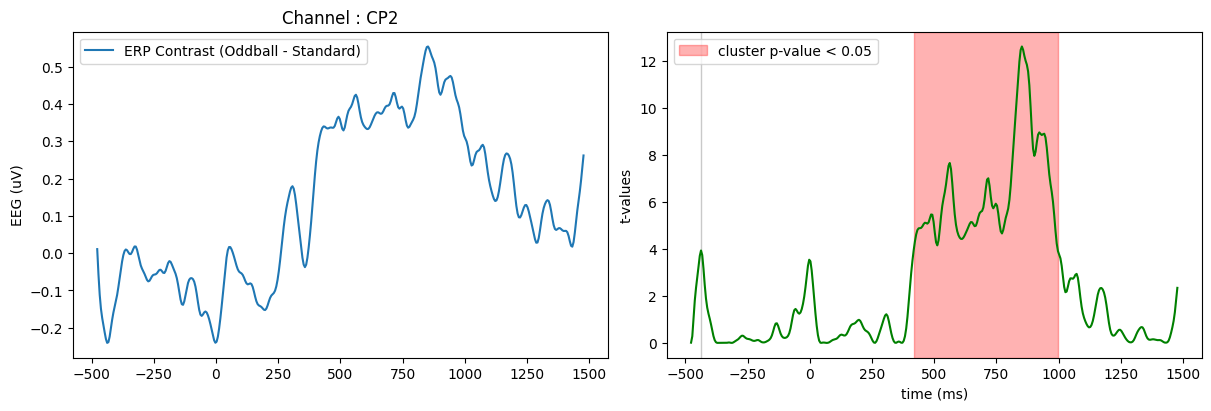

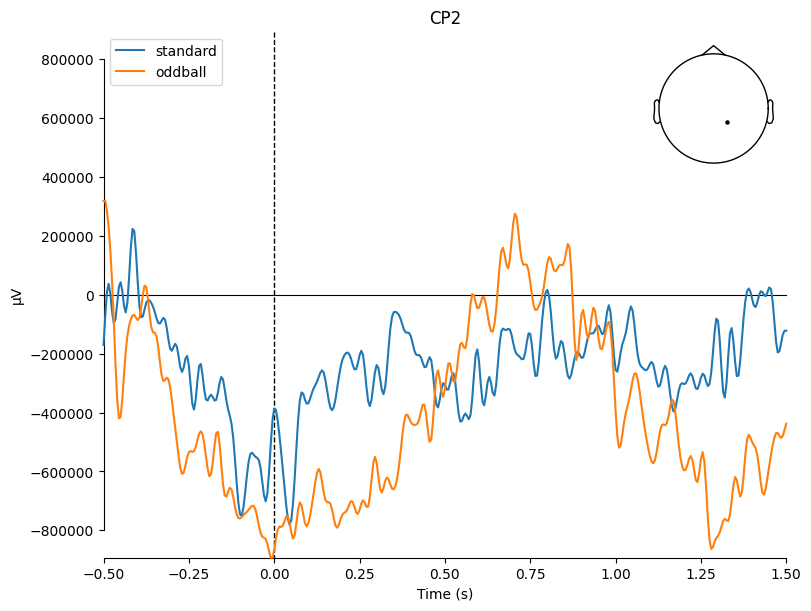

In [13]:
chnls = ['CP2', 'CP1','Cz', 'Pz']

avg = True 
if avg == True:
    ch_l = ['CP2']
else:
    ch_l = ['CP2', 'CP1','Cz', 'Pz']
w=10
for chl in ch_l: 

    if avg == True:
        epochs_odd_Cz = epochs_aff_odd_all_filt_stat.copy().crop(crop_min,crop_max).pick(chnls).get_data().mean(axis=1)
        epochs_typ_Cz = epochs_aff_typ_all_filt_stat.copy().crop(crop_min,crop_max).pick(chnls).get_data().mean(axis=1)
        epochs_odd_Cz = moving_average(epochs_odd_Cz, w)
        epochs_typ_Cz = moving_average(epochs_typ_Cz, w)
        
        evoked_typ = epochs_aff_typ_all_filt_stat.copy().crop(crop_min,crop_max).pick(chnls[0]).average()
        evoked_odd = epochs_aff_odd_all_filt_stat.copy().crop(crop_min,crop_max).pick(chnls[0]).average()
        
    else:
        epochs_odd_Cz = epochs_aff_odd_all_filt_stat.copy().crop(crop_min,crop_max).pick([chl]).get_data()[:, 0, :]  # only 1 channel as 3D matrix
        epochs_typ_Cz = epochs_aff_typ_all_filt_stat.copy().crop(crop_min,crop_max).pick([chl]).get_data()[:, 0, :]  # only 1 channel as 3D matrix
        epochs_odd_Cz = moving_average(epochs_odd_Cz, w)
        epochs_typ_Cz= moving_average(epochs_typ_Cz, w)
        
        evoked_typ = epochs_aff_typ_all_filt_stat.copy().crop(crop_min,crop_max).pick([chl]).average()
        evoked_odd = epochs_aff_odd_all_filt_stat.copy().crop(crop_min,crop_max).pick([chl]).average()
    
    
    import scipy
    threshold = 6.0
    n_observations = epochs_typ_Cz.shape[0]
    n_conditions =2


    stat_fun = partial(mne.stats.ttest_ind_no_p, sigma=1e-3)
    n_permutations = 5000
    p_threshold = 0.001
    t_threshold = -stats.distributions.t.ppf(p_threshold / 2., 48 - 1)
    #    stat_fun=stat_fun,



    pval = 0.05  # arbitrary
    dfn = n_conditions - 1  # degrees of freedom numerator
    dfd = n_observations - n_conditions  # degrees of freedom denominator
    thresh = scipy.stats.f.ppf(1 - pval, dfn=dfn, dfd=dfd)  # F distribution



    F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
        [epochs_odd_Cz, epochs_typ_Cz],
        out_type="mask",
        n_permutations=n_permutations,
        threshold=thresh,
        tail=0,
        seed=np.random.default_rng(seed=8675309),
    )


    times = 1e3 * epochs_aff_odd.copy().crop(crop_min,crop_max).times  # change unit to ms
    times = moving_average(times, w)
    
    fig, (ax, ax2) = plt.subplots(1, 2, figsize=(12, 4), layout="constrained")
    channel =chl


    # Compute the difference in evoked to determine which was greater since
    # we used a 1-way ANOVA which tested for a difference in population means
    evoked_odd_Cz = epochs_odd_Cz.mean(axis=0)
    evoked_typ_Cz = epochs_typ_Cz.mean(axis=0)
    evoked_power_contrast = evoked_odd_Cz - evoked_typ_Cz
    signs = np.sign(evoked_power_contrast)

    # Create new stats image with only significant clusters
    F_obs_plot = np.nan * np.ones_like(F_obs)
    for c, p_val in zip(clusters, cluster_p_values):
        if p_val <= 0.05:
            F_obs_plot[c] = F_obs[c] * signs[c]


    ax.set_title("Channel : " + channel)

    ax.plot(
        times,
        epochs_odd_Cz.mean(axis=0) - epochs_typ_Cz.mean(axis=0),
        label="ERP Contrast (Oddball - Standard)",
    )
    ax.set_ylabel("EEG (uV)")
    ax.legend()

    vline1 = []
    
    for i_c, c in enumerate(clusters):
        c = c[0]
        if cluster_p_values[i_c] <= 0.05:
            
            vline1.append(times[c.start]/1000)
            vline1.append(times[c.stop - 1]/1000)
            
            h = ax2.axvspan(times[c.start], times[c.stop - 1], color="r",fill=True,  alpha=0.3)
            ax2.legend((h,), ("cluster p-value < 0.05",))

        else:
            ax2.axvspan(times[c.start], times[c.stop - 1], color=(0.3, 0.3, 0.3), fill=True, alpha=0.3)


    hf = plt.plot(times, F_obs, "g")
    ax2.set_xlabel("time (ms)")
    ax2.set_ylabel("t-values")

    
    mne.viz.plot_compare_evokeds(
        dict(standard=evoked_typ,oddball=evoked_odd),
        legend="upper left",
        show_sensors="upper right",title=channel
    )


In [14]:
crop_min,crop_max

(-0.5, 1.5)

stat_fun(H1): min=6.536189977624272e-05 max=12.596239504647807


C:\Users\malann\AppData\Local\Temp\ipykernel_46332\4144490724.py:12: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_odd_Cz = epochs_aff_odd_all_filt_stat.copy().crop(crop_min,crop_max).pick(chnls).get_data().mean(axis=1)
C:\Users\malann\AppData\Local\Temp\ipykernel_46332\4144490724.py:13: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_typ_Cz = epochs_aff_typ_all_filt_stat.copy().crop(crop_min,crop_max).pick(chnls).get_data().mean(axis=1)


Running initial clustering …
Found 5 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

0.005


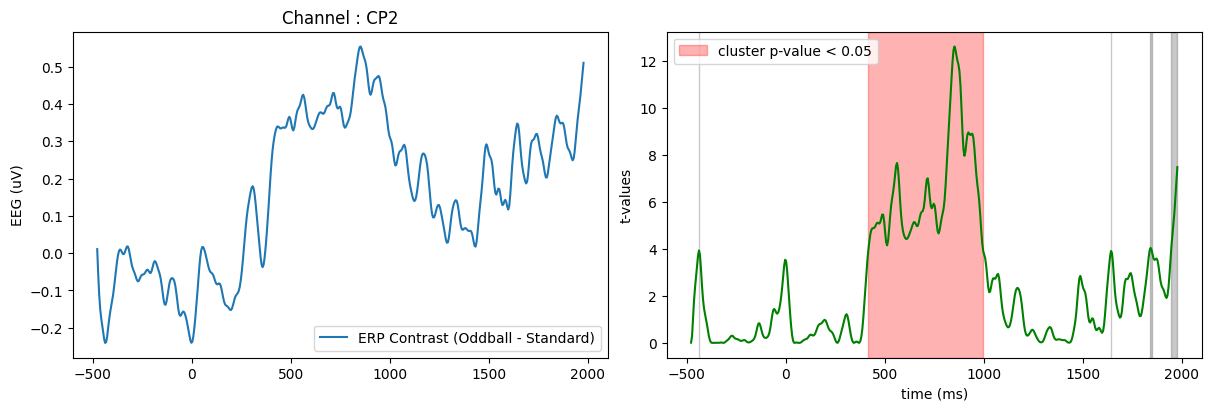

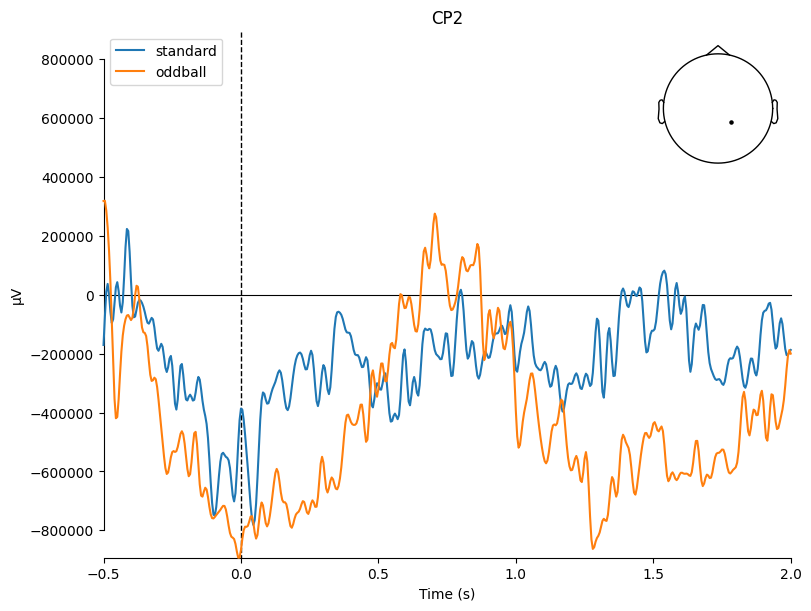

In [15]:
chnls = ['CP2', 'CP1','Cz', 'Pz']
crop_min,crop_max = -0.5, 2.0
avg = True 
if avg == True:
    ch_l = ['CP2']
else:
    ch_l = ['CP2', 'CP1','Cz', 'Pz']
w=10
for chl in ch_l: 

    if avg == True:
        epochs_odd_Cz = epochs_aff_odd_all_filt_stat.copy().crop(crop_min,crop_max).pick(chnls).get_data().mean(axis=1)
        epochs_typ_Cz = epochs_aff_typ_all_filt_stat.copy().crop(crop_min,crop_max).pick(chnls).get_data().mean(axis=1)
        epochs_odd_Cz = moving_average(epochs_odd_Cz, w)
        epochs_typ_Cz = moving_average(epochs_typ_Cz, w)
        
        evoked_typ = epochs_aff_typ_all_filt_stat.copy().crop(crop_min,crop_max).pick(chnls[0]).average()
        evoked_odd = epochs_aff_odd_all_filt_stat.copy().crop(crop_min,crop_max).pick(chnls[0]).average()
        
    else:
        epochs_odd_Cz = epochs_aff_odd_all_filt_stat.copy().crop(crop_min,crop_max).pick([chl]).get_data()[:, 0, :]  # only 1 channel as 3D matrix
        epochs_typ_Cz = epochs_aff_typ_all_filt_stat.copy().crop(crop_min,crop_max).pick([chl]).get_data()[:, 0, :]  # only 1 channel as 3D matrix
        epochs_odd_Cz = moving_average(epochs_odd_Cz, w)
        epochs_typ_Cz= moving_average(epochs_typ_Cz, w)
        
        evoked_typ = epochs_aff_typ_all_filt_stat.copy().crop(crop_min,crop_max).pick([chl]).average()
        evoked_odd = epochs_aff_odd_all_filt_stat.copy().crop(crop_min,crop_max).pick([chl]).average()
    
    
    import scipy
    threshold = 6.0
    n_observations = epochs_typ_Cz.shape[0]
    n_conditions =2


    stat_fun = partial(mne.stats.ttest_ind_no_p, sigma=1e-3)
    n_permutations = 5000
    p_threshold = 0.001
    t_threshold = -stats.distributions.t.ppf(p_threshold / 2., 48 - 1)
    #    stat_fun=stat_fun,



    pval = 0.05  # arbitrary
    dfn = n_conditions - 1  # degrees of freedom numerator
    dfd = n_observations - n_conditions  # degrees of freedom denominator
    thresh = scipy.stats.f.ppf(1 - pval, dfn=dfn, dfd=dfd)  # F distribution



    F_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
        [epochs_odd_Cz, epochs_typ_Cz],
        out_type="mask",
        n_permutations=n_permutations,
        threshold=thresh,
        tail=0,
        seed=np.random.default_rng(seed=8675309),
    )


    times = 1e3 * epochs_aff_odd.copy().crop(crop_min,crop_max).times  # change unit to ms
    times = moving_average(times, w)
    
    fig, (ax, ax2) = plt.subplots(1, 2, figsize=(12, 4), layout="constrained")
    channel =chl


    # Compute the difference in evoked to determine which was greater since
    # we used a 1-way ANOVA which tested for a difference in population means
    evoked_odd_Cz = epochs_odd_Cz.mean(axis=0)
    evoked_typ_Cz = epochs_typ_Cz.mean(axis=0)
    evoked_power_contrast = evoked_odd_Cz - evoked_typ_Cz
    signs = np.sign(evoked_power_contrast)

    # Create new stats image with only significant clusters
    F_obs_plot = np.nan * np.ones_like(F_obs)
    for c, p_val in zip(clusters, cluster_p_values):
        if p_val <= 0.05:
            F_obs_plot[c] = F_obs[c] * signs[c]


    ax.set_title("Channel : " + channel)

    ax.plot(
        times,
        epochs_odd_Cz.mean(axis=0) - epochs_typ_Cz.mean(axis=0),
        label="ERP Contrast (Oddball - Standard)",
    )
    ax.set_ylabel("EEG (uV)")
    ax.legend()

    vline1 = []
    
    for i_c, c in enumerate(clusters):
        c = c[0]
        if cluster_p_values[i_c] <= 0.05:
            print(cluster_p_values[i_c])
            
            vline1.append(times[c.start]/1000)
            vline1.append(times[c.stop - 1]/1000)
            time_start = times[c.start]
            time_stop = times[c.stop]
            
            
            h = ax2.axvspan(times[c.start], times[c.stop - 1], color="r",fill=True,  alpha=0.3)
            ax2.legend((h,), ("cluster p-value < 0.05",))

        else:
            ax2.axvspan(times[c.start], times[c.stop - 1], color=(0.3, 0.3, 0.3), fill=True, alpha=0.3)


    hf = plt.plot(times, F_obs, "g")
    ax2.set_xlabel("time (ms)")
    ax2.set_ylabel("t-values")

    
    mne.viz.plot_compare_evokeds(
        dict(standard=evoked_typ,oddball=evoked_odd),
        legend="upper left",
        show_sensors="upper right",title=channel
    )


In [16]:
cluster_p_values[i_c]

0.4704

In [17]:
time_stop

1002.5

In [18]:
time_start

417.5

In [19]:
(times[c.stop-1]- times[c.start])/1000 

0.03

In [20]:
times[c.start]

1947.5

C:\Users\malann\AppData\Local\Temp\ipykernel_46332\2576467010.py:60: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epoch_odd_all_Cz.append(epochs_aff_odd_all_filt[i].copy().crop(crop_min,crop_max).pick(elec).get_data())
C:\Users\malann\AppData\Local\Temp\ipykernel_46332\2576467010.py:61: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epoch_odd_NE_all_Cz.append(epochs_aff_odd_NE_all_filt[i].copy().crop(crop_min,crop_max).pick(elec).get_data())
C:\Users\malann\AppData\Local\Temp\ipykernel_46332\2576467010.py:62: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epoch_typ_all_Cz.append(epochs_aff_typ_all_filt[i].copy().crop(crop_min,crop_max).pick(elec).get_data())
C:\Users\malann\AppData\Local\Temp\ipykernel_46332\2576

mean of standard (subset1) 0.006858154399289378
std of standard (subset1) 0.08132911257642947
mean of oddball response 0.39841752767442346
std of oddball response 0.08990098030246368


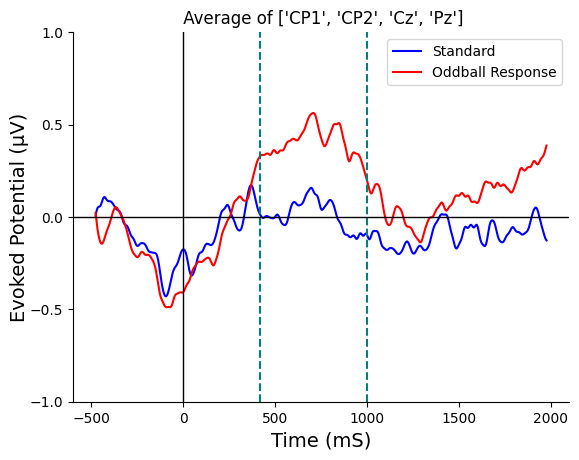

C:\Users\malann\AppData\Local\Temp\ipykernel_46332\2576467010.py:60: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epoch_odd_all_Cz.append(epochs_aff_odd_all_filt[i].copy().crop(crop_min,crop_max).pick(elec).get_data())
C:\Users\malann\AppData\Local\Temp\ipykernel_46332\2576467010.py:61: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epoch_odd_NE_all_Cz.append(epochs_aff_odd_NE_all_filt[i].copy().crop(crop_min,crop_max).pick(elec).get_data())
C:\Users\malann\AppData\Local\Temp\ipykernel_46332\2576467010.py:62: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epoch_typ_all_Cz.append(epochs_aff_typ_all_filt[i].copy().crop(crop_min,crop_max).pick(elec).get_data())
C:\Users\malann\AppData\Local\Temp\ipykernel_46332\2576

<Figure size 640x480 with 0 Axes>

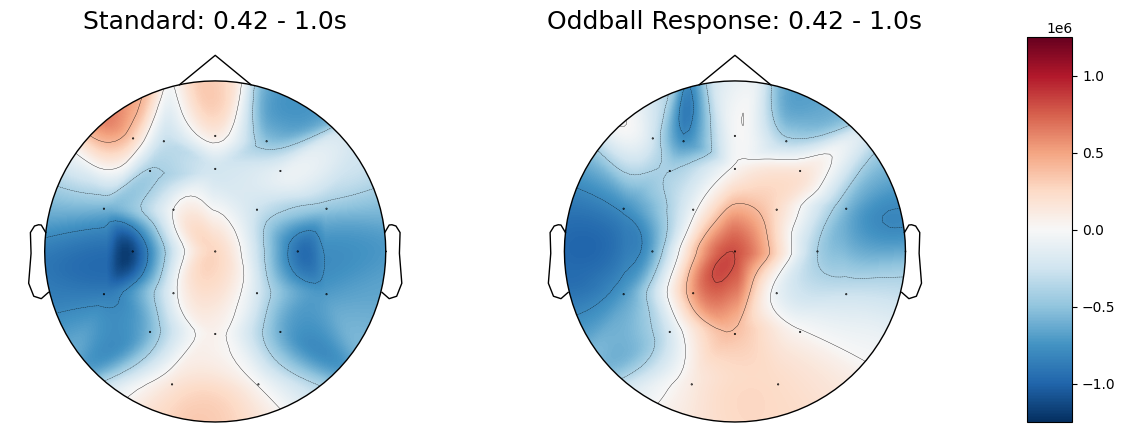

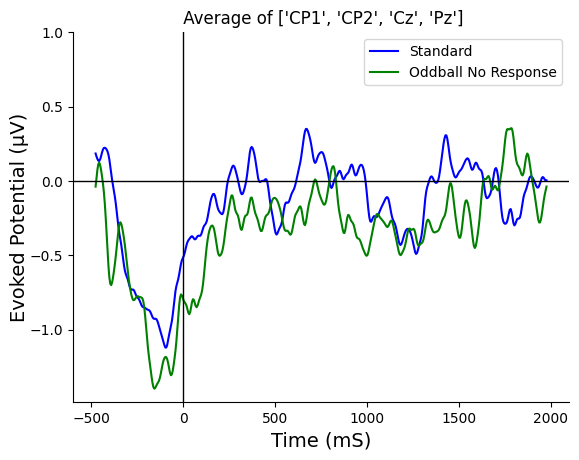

<Figure size 640x480 with 0 Axes>

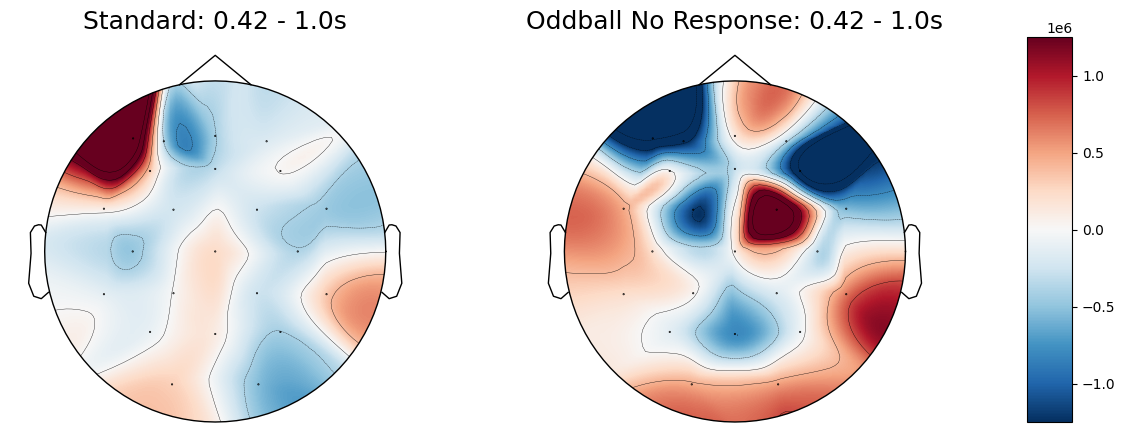

In [21]:
resp = {'007':0,'008':1,'011':2,'013':3}
non_resp = {'008':1,'011':2,'013':3,'014':4,'015':5}
event_id = dict( Standard=1,Oddball=101)
ch_picks = ['AF7',  'AF4', 'AFz', 'AF3', 'F4', 'Fz', 'F3', 'FC6', 'FC2', 'FC1', 'FC5',
            'C4', 'Cz', 'C3', 'CP6', 'CP2', 'CP1', 'CP5', 'Pz','P4', 'P3', 'O2', 'O1']

ERP = 'Pe'
avg = True

if avg==True and ERP == 'ERN':
    elec = ['Fz','Cz','FC1','FC2']
    t_center = 0.015
    t_width = 0.070

elif avg==True and ERP == 'Pe':    
    elec = ['CP1','CP2','Cz','Pz']
    t_width = (time_stop- time_start)/1000
    t_center = time_start/1000 + t_width/2 
elif avg==False and ERP == 'ERN':
    elec = ['Cz']
    t_center = 0.015
    t_width = 0.070
elif avg==False and ERP == 'Pe':    
    elec = ['Cz']
    t_width = (time_stop- time_start)/1000
    t_center = time_start/1000 + t_width/2 
    
crop_min,crop_max = -0.5,2
task_res = ['Responders', 'Non Responders']


for ires, res in enumerate(task_res):
    if res == 'Responders':
        resp_idx = list(resp.values())
    else:
        resp_idx = list(non_resp.values())
    evoked_odd_all=[]
    evoked_odd_NE_all=[]
    evoked_typ_all=[]
    evoked_typ_NE_all=[]

    evoked_odd_all_Cz = []
    evoked_odd_NE_all_Cz = [] 
    evoked_typ_all_Cz=[]
    evoked_typ_NE_all_Cz=[]
        
    epoch_odd_all_Cz=[]
    epoch_odd_NE_all_Cz=[]
    epoch_typ_all_Cz=[]
    epoch_typ_NE_all_Cz=[]   
   
    
    for i in resp_idx:
        if avg==True:
            evoked_odd_all_Cz.append(epochs_aff_odd_all_filt[i].copy().crop(crop_min,crop_max).pick(elec).average().get_data().mean(axis=0))
            evoked_odd_NE_all_Cz.append(epochs_aff_odd_NE_all_filt[i].copy().crop(crop_min,crop_max).pick(elec).average().get_data().mean(axis=0))
            evoked_typ_all_Cz.append(epochs_aff_typ_all_filt[i].copy().crop(crop_min,crop_max).pick(elec).average().get_data().mean(axis=0))
            evoked_typ_NE_all_Cz.append(epochs_aff_typ_NE_all_filt[i].copy().crop(crop_min,crop_max).pick(elec).average().get_data().mean(axis=0))

            epoch_odd_all_Cz.append(epochs_aff_odd_all_filt[i].copy().crop(crop_min,crop_max).pick(elec).get_data())
            epoch_odd_NE_all_Cz.append(epochs_aff_odd_NE_all_filt[i].copy().crop(crop_min,crop_max).pick(elec).get_data())
            epoch_typ_all_Cz.append(epochs_aff_typ_all_filt[i].copy().crop(crop_min,crop_max).pick(elec).get_data())
            epoch_typ_NE_all_Cz.append(epochs_aff_typ_NE_all_filt[i].copy().crop(crop_min,crop_max).pick(elec).get_data())
                       
        else:
            evoked_odd_all_Cz.append(epochs_aff_odd_all_filt[i].copy().crop(crop_min,crop_max).pick(elec).average().get_data()[0])
            evoked_odd_NE_all_Cz.append(epochs_aff_odd_NE_all_filt[i].copy().crop(crop_min,crop_max).pick(elec).average().get_data().mean(axis=0))
            evoked_typ_all_Cz.append(epochs_aff_typ_all_filt[i].copy().crop(crop_min,crop_max).pick(elec).average().get_data()[0])
            evoked_typ_NE_all_Cz.append(epochs_aff_typ_NE_all_filt[i].copy().crop(crop_min,crop_max).pick(elec).average().get_data().mean(axis=0))

        evoked_odd_all.append(epochs_aff_odd_all_filt[i].copy().pick(ch_picks).average().get_data())
        evoked_odd_NE_all.append(epochs_aff_odd_NE_all_filt[i].copy().pick(ch_picks).average().get_data())
        evoked_typ_all.append(epochs_aff_typ_all_filt[i].copy().pick(ch_picks).average().get_data())
        evoked_typ_NE_all.append(epochs_aff_typ_NE_all_filt[i].copy().pick(ch_picks).average().get_data())

    evoked_odd_all=np.array(evoked_odd_all)
    evoked_odd_NE_all=np.array(evoked_odd_NE_all)
    evoked_typ_all_Cz=np.array(evoked_typ_all_Cz)
    evoked_typ_NE_all_Cz=np.array(evoked_typ_NE_all_Cz)    


    #epoch_odd_all_Cz=np.array(epoch_odd_all_Cz)
    #epoch_odd_NE_all_Cz=np.array(epoch_odd_NE_all_Cz)
    #epoch_typ_all_Cz=np.array(epoch_typ_all_Cz)
    #epoch_typ_NE_all_Cz=np.array(epoch_typ_NE_all_Cz)
    
    
    
    evoked_odd_avg_data = evoked_odd_all.mean(axis=0)
    evoked_odd_NE_avg_data = evoked_odd_NE_all.mean(axis=0)
        
    evoked_typ_all=np.array(evoked_typ_all)
    evoked_typ_NE_all=np.array(evoked_typ_NE_all)
    
    evoked_odd_all_Cz=np.array(evoked_odd_all_Cz)
    evoked_odd_NE_all_Cz=np.array(evoked_odd_NE_all_Cz)

    evoked_typ_avg_data = evoked_typ_all.mean(axis=0)
    evoked_typ_NE_avg_data = evoked_typ_NE_all.mean(axis=0)
    

    
    if res == 'Responders':
        X1_evk_odd_E=np.array(evoked_odd_all_Cz)
        X1_evk_odd_NE=np.array(evoked_odd_NE_all_Cz)
        X2_evk_typ_E=np.array(evoked_typ_all_Cz)
        X2_evk_typ_NE=np.array(evoked_typ_NE_all_Cz) 
    else:
        X3_evk_odd_E=np.array(evoked_odd_all_Cz)
        X3_evk_odd_NE=np.array(evoked_odd_NE_all_Cz)
        X4_evk_typ_E=np.array(evoked_typ_all_Cz)
        X4_evk_typ_NE=np.array(evoked_typ_NE_all_Cz)
    
    
    
    evoked_odd_avg = mne.EvokedArray(evoked_odd_avg_data, epochs_aff_odd_all_filt[i].copy().pick(ch_picks).info, tmin = epochs_aff_odd_all_filt[i].copy().pick(ch_picks).tmin, kind='average', baseline=None, verbose=None)
    evoked_odd_NE_avg = mne.EvokedArray(evoked_odd_NE_avg_data, epochs_aff_odd_NE_all_filt[i].copy().pick(ch_picks).info, tmin = epochs_aff_odd_NE_all_filt[i].copy().pick(ch_picks).tmin, kind='average', baseline=None, verbose=None)
    evoked_typ_avg = mne.EvokedArray(evoked_typ_avg_data, epochs_aff_typ_all_filt[i].copy().pick(ch_picks).info, tmin = epochs_aff_typ_all_filt[i].copy().pick(ch_picks).tmin, kind='average', baseline=None, verbose=None)
    evoked_typ_NE_avg = mne.EvokedArray(evoked_typ_NE_avg_data, epochs_aff_typ_NE_all_filt[i].copy().pick(ch_picks).info, tmin = epochs_aff_typ_NE_all_filt[i].copy().pick(ch_picks).tmin, kind='average', baseline=None, verbose=None)
        
    #evoked_typ_avg.copy().crop(crop_min,crop_max).plot_joint()
    #evoked_odd_avg.copy().crop(crop_min,crop_max).plot_joint()
    w=10
    time = evoked_typ_avg.copy().crop(crop_min,crop_max).times*1000
    time = moving_average(time, w)

    mean_odd = moving_average(evoked_odd_all_Cz.mean(axis=0),w)
    mean_odd_NE = moving_average(evoked_odd_NE_all_Cz.mean(axis=0),w)
    mean_typ = moving_average(evoked_typ_all_Cz.mean(axis=0),w)
    mean_typ_NE = moving_average(evoked_typ_NE_all_Cz.mean(axis=0),w)
    
    var_odd = moving_average(sem(evoked_odd_all_Cz,axis=0),w)
    var_odd_NE = moving_average(sem(evoked_odd_NE_all_Cz,axis=0),w)
    var_typ = moving_average(sem(evoked_typ_all_Cz,axis=0),w)
    var_typ_NE = moving_average(sem(evoked_typ_NE_all_Cz,axis=0),w)
    
    
    plt.figure(1)
    
    
    time_stop- time_start
    
    if res== 'Responders':
        plt.plot(time,mean_typ,color='b')
        plt.plot(time,mean_odd,color='r')
        
        times_roi = [time_start, time_stop]
        
        #plt.fill_between(times_roi, -1, 1, alpha=0.1,color='r')
        
        plt.axvline(x=times_roi[0],color='teal', ls='--')
        plt.axvline(x=times_roi[1],color='teal', ls='--')
        
        #plt.fill_between(time,mean_typ+var_typ, mean_typ-var_typ,alpha=0.2,color='b')
        plt.legend(['Standard','Oddball Response'])
            
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['bottom'].set_visible(True)
        plt.gca().spines['left'].set_visible(True)
        
        print(f'mean of standard (subset1) {np.mean(mean_typ[184:300])}')
        print(f'std of standard (subset1) {np.std(mean_typ[184:300])}')
        print(f'mean of oddball response {np.mean(mean_odd[184:300])}')
        print(f'std of oddball response {np.std(mean_odd[184:300])}')
           

    elif res== 'Non Responders':
        plt.plot(time,mean_typ_NE,color='b')
        plt.plot(time,mean_odd_NE,color='g')
        #plt.fill_between(time,mean_odd_NE+var_odd_NE, mean_odd_NE-var_odd_NE,alpha=0.2,color='g')
        #plt.fill_between(time,mean_typ_NE+var_typ_NE, mean_typ_NE-var_typ_NE,alpha=0.2,color='b')
        plt.legend(['Standard','Oddball No Response'])
        
        
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['bottom'].set_visible(True)
        plt.gca().spines['left'].set_visible(True)

    plt.axvline(0, linewidth=1, color="black")
    plt.axhline(0, linewidth=1, color="black")
    

    if avg==True:
        plt.title(f' Average of {elec}')
    else:
        plt.title(f'{res} : {elec}')
    plt.xlabel('Time (mS)',fontsize = 14)
    plt.ylabel('Evoked Potential (µV)',fontsize = 14,labelpad=0.5) 
    plt.yticks(np.arange(-1,1.1,0.5))
    if res == 'Responderss':
        plt.fill_betweenx(range(-2,2), 0.5,1,color='gray', alpha=0.5)
        
    plt.show()    
    plt.figure(2)
    
    width_ratios=[10,10,1]
        
    fig,ax = plt.subplots(1,3,figsize=(14,5), gridspec_kw={"width_ratios": width_ratios})
    vmin,vamx = -1.25e6,1.25e6
    
    
    if res== 'Responders':
        evoked_typ_avg.plot_topomap(times=t_center, average=t_width, vlim=(vmin,vamx),axes=ax[0],colorbar=False,show=False)
        ax[0].set_title(f'Standard: {round(t_center-t_width/2,2)} - {round(t_center+t_width/2,2)}s',fontsize = 18)
        evoked_odd_avg.plot_topomap(times=t_center, average=t_width, vlim=(vmin,vamx),axes=ax[1],colorbar=False,show=False)
        ax[1].set_title(f'Oddball Response: {round(t_center-t_width/2,2)} - {round(t_center+t_width/2,2)}s',fontsize = 18)
        
    elif res== 'Non Responders':
        evoked_typ_NE_avg.plot_topomap(times=t_center, average=t_width, vlim=(vmin,vamx),axes=ax[0],colorbar=False,show=False)
        ax[0].set_title(f'Standard: {round(t_center-t_width/2,2)} - {round(t_center+t_width/2,2)}s',fontsize = 18)
        evoked_odd_NE_avg.plot_topomap(times=t_center, average=t_width, vlim=(vmin,vamx),axes=ax[1],colorbar=False,show=False)
        ax[1].set_title(f'Oddball No Response: {round(t_center-t_width/2,2)} - {round(t_center+t_width/2,2)}s',fontsize = 18)
    #fig.suptitle(f'{res}',fontsize = 24)
    fig.colorbar(ax[0].images[-1], cax=ax[-1]).ax.set_yscale("linear")





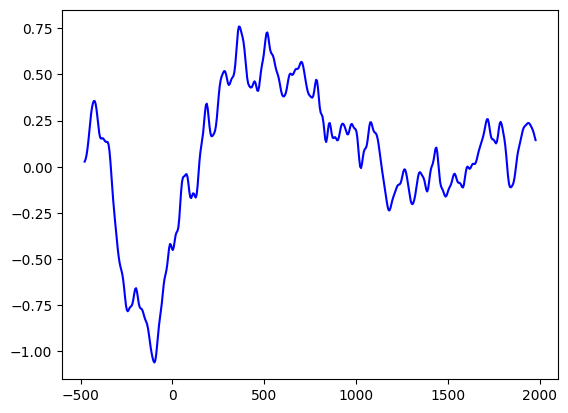

In [47]:
plt.plot(time,mean_typ,color='b')

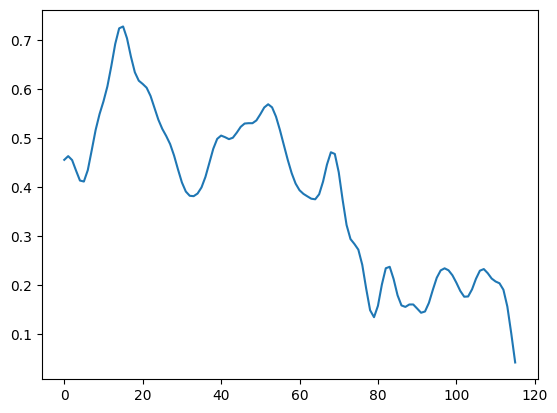

In [46]:
plt.plot(mean_typ[184:300])

SyntaxError: unterminated string literal (detected at line 1) (1857571126.py, line 1)

In [41]:
np.mean(mean_odd[184:300])
np.std(mean_odd[184:300])

0.4317739617548232

0.3484403269464067

In [31]:
epochs = mne.concatenate_epochs([epochs_aff_typ_all_filt_stat,epochs_aff_odd_all_filt_stat])
epochs=epochs.copy().crop(crop_min,1.5)
adjacency, ch_names = find_ch_adjacency(epochs.info, ch_type="eeg")
event_id = {'1': 1, '101': 101}
X = [epochs[event_name].get_data(copy=False) for event_name in event_id]
X = [np.transpose(x, (0, 2, 1)) for x in X]

Adding metadata with 9 columns
406 matching events found
Applying baseline correction (mode: mean)
Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 23


In [32]:
X[0].shape

(203, 401, 23)

In [33]:
# We are running an F test, so we look at the upper tail
# see also: https://stats.stackexchange.com/a/73993
tail = 1

# We want to set a critical test statistic (here: F), to determine when
# clusters are being formed. Using Scipy's percent point function of the F
# distribution, we can conveniently select a threshold that corresponds to
# some alpha level that we arbitrarily pick.
alpha_cluster_forming = 0.001

# For an F test we need the degrees of freedom for the numerator
# (number of conditions - 1) and the denominator (number of observations
# - number of conditions):
n_conditions = len(event_id)
n_observations = len(X[0])
dfn = n_conditions - 1
dfd = n_observations - n_conditions

# Note: we calculate 1 - alpha_cluster_forming to get the critical value
# on the right tail
f_thresh = scipy.stats.f.ppf(1 - alpha_cluster_forming, dfn=dfn, dfd=dfd)

# run the cluster based permutation analysis
cluster_stats = spatio_temporal_cluster_test(
    X,
    n_permutations=1000,
    threshold=f_thresh,
    tail=tail,
    n_jobs=None,
    buffer_size=None,
    adjacency=adjacency,
)
F_obs, clusters, p_values, _ = cluster_stats

stat_fun(H1): min=2.78215301048046e-07 max=15.459378148040537
Running initial clustering …
Found 7 clusters


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

In [34]:
# We subselect clusters that we consider significant at an arbitrarily
# picked alpha level: "p_accept".
# NOTE: remember the caveats with respect to "significant" clusters that
# we mentioned in the introduction of this tutorial!
p_accept = 0.05
good_cluster_inds = np.where(p_values < p_accept)[0]

# configure variables for visualization
colors = {"1": "crimson", "101": "steelblue"}
linestyles = {"1": "-", "101": "--"}

# organize data for plotting
evokeds = {cond: epochs[cond].average() for cond in event_id}

# loop over clusters
for i_clu, clu_idx in enumerate(good_cluster_inds):
    # unpack cluster information, get unique indices
    time_inds, space_inds = np.squeeze(clusters[clu_idx])
    ch_inds = np.unique(space_inds)
    time_inds = np.unique(time_inds)

    # get topography for F stat
    f_map = F_obs[time_inds, ...].mean(axis=0)

    # get signals at the sensors contributing to the cluster
    sig_times = epochs.times[time_inds]

    # create spatial mask
    mask = np.zeros((f_map.shape[0], 1), dtype=bool)
    mask[ch_inds, :] = True

    # initialize figure
    fig, ax_topo = plt.subplots(1, 1, figsize=(10, 3), layout="constrained")

    # plot average test statistic and mark significant sensors
    f_evoked = mne.EvokedArray(f_map[:, np.newaxis], epochs.info, tmin=0)
    f_evoked.plot_topomap(
        times=0,
        mask=mask,
        axes=ax_topo,
        cmap="Reds",
        vlim=(np.min, np.max),
        show=False,
        colorbar=False,
        mask_params=dict(markersize=10),
    )
    image = ax_topo.images[0]

    # remove the title that would otherwise say "0.000 s"
    ax_topo.set_title("")

    # create additional axes (for ERF and colorbar)
    divider = make_axes_locatable(ax_topo)

    # add axes for colorbar
    ax_colorbar = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(image, cax=ax_colorbar)
    ax_topo.set_xlabel(
        "Averaged F-map ({:0.3f} - {:0.3f} s)".format(*sig_times[[0, -1]])
    )

    # add new axis for time courses and plot time courses
    ax_signals = divider.append_axes("right", size="300%", pad=1.2)
    title = f"Cluster #{i_clu + 1}, {len(ch_inds)} sensor"
    if len(ch_inds) > 1:
        title += "s (mean)"
    plot_compare_evokeds(
        evokeds,
        title=title,
        picks=ch_inds,
        axes=ax_signals,
        colors=colors,
        linestyles=linestyles,
        show=False,
        split_legend=True,
        truncate_yaxis="auto",
    )

    # plot temporal cluster extent
    ymin, ymax = ax_signals.get_ylim()
    ax_signals.fill_betweenx(
        (ymin, ymax), sig_times[0], sig_times[-1], color="orange", alpha=0.3
    )

plt.show()

In [ ]:
decim = 4
freqs = np.arange(7, 30, 3)  # define frequencies of interest
n_cycles = freqs / freqs[0]

epochs_power = list()
for condition in [epochs[k] for k in ("1", "101")]:
    this_tfr = condition.compute_tfr(
        method="morlet",
        freqs=freqs,
        n_cycles=n_cycles,
        decim=decim,
        average=False,
        return_itc=False,
    )
    this_tfr.apply_baseline(mode="ratio", baseline=(None, 0))
    epochs_power.append(this_tfr.data)

# transpose again to (epochs, frequencies, times, channels)
X = [np.transpose(x, (0, 2, 3, 1)) for x in epochs_power]

In [ ]:
# our data at each observation is of shape frequencies × times × channels
tfr_adjacency = combine_adjacency(len(freqs), len(this_tfr.times), adjacency)
# This time we don't calculate a threshold based on the F distribution.
# We might as well select an arbitrary threshold for cluster forming
tfr_threshold = 15.0

# run cluster based permutation analysis
cluster_stats = spatio_temporal_cluster_test(
    X,
    n_permutations=1000,
    threshold=tfr_threshold,
    tail=1,
    n_jobs=None,
    buffer_size=None,
    adjacency=tfr_adjacency,
)
p_accept=0.05


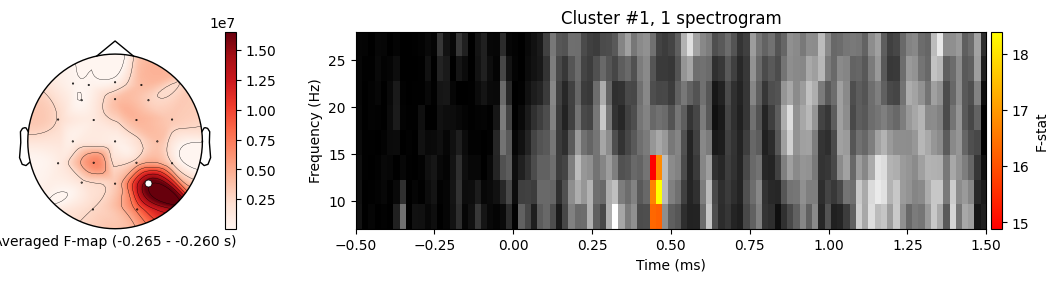

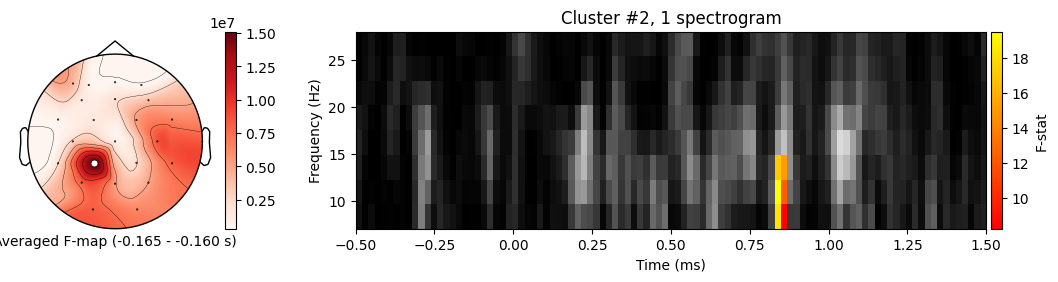

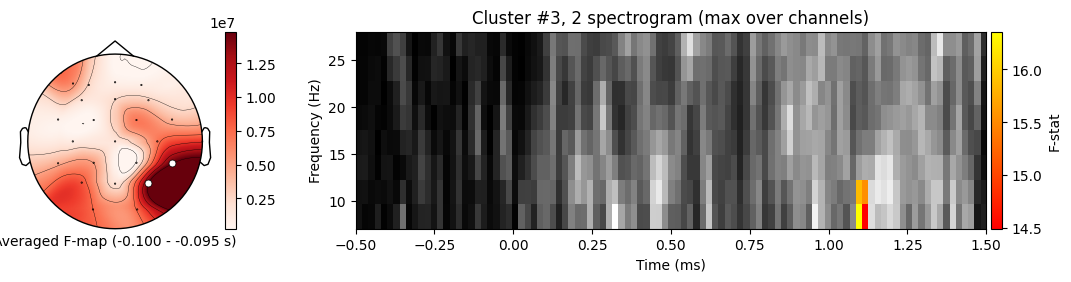

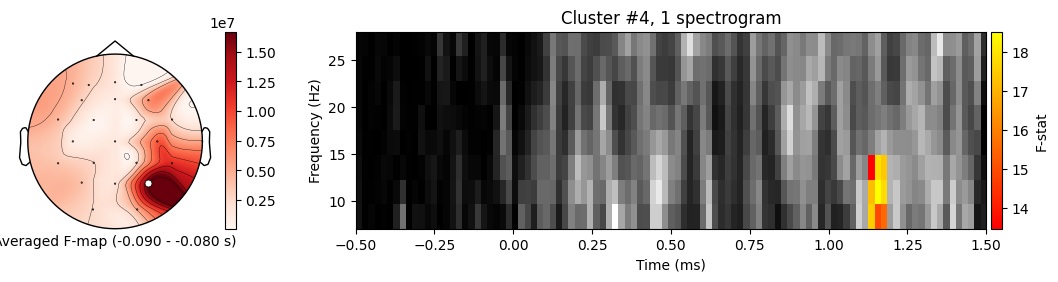

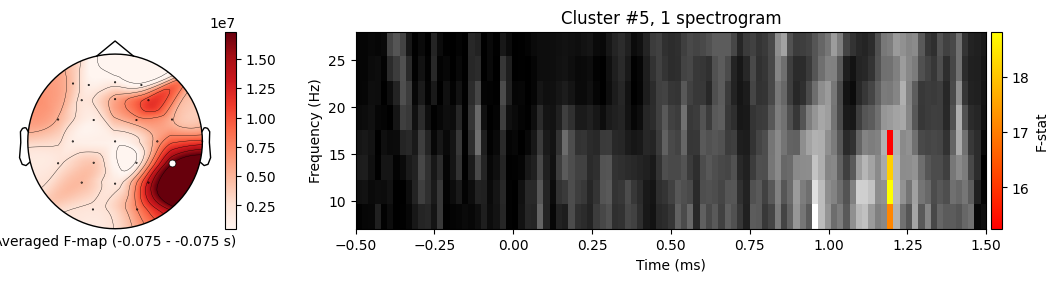

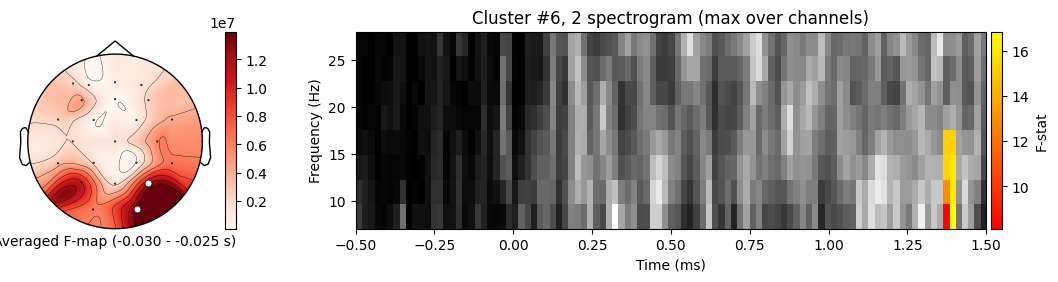

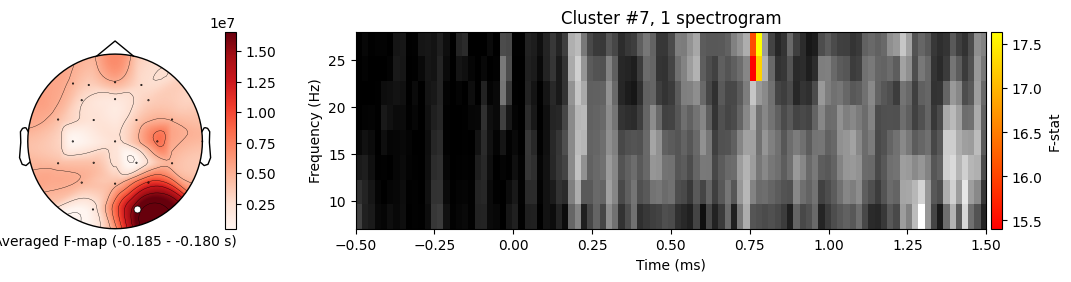

In [247]:
F_obs, clusters, p_values, _ = cluster_stats
good_cluster_inds = np.where(p_values < p_accept)[0]

for i_clu, clu_idx in enumerate(good_cluster_inds):
    # unpack cluster information, get unique indices
    freq_inds, time_inds, space_inds = clusters[clu_idx]
    ch_inds = np.unique(space_inds)
    time_inds = np.unique(time_inds)
    freq_inds = np.unique(freq_inds)

    # get topography for F stat
    f_map = F_obs[freq_inds].mean(axis=0)
    f_map = f_map[time_inds].mean(axis=0)

    # get signals at the sensors contributing to the cluster
    sig_times = epochs.times[time_inds]

    # initialize figure
    fig, ax_topo = plt.subplots(1, 1, figsize=(10, 3), layout="constrained")

    # create spatial mask
    mask = np.zeros((f_map.shape[0], 1), dtype=bool)
    mask[ch_inds, :] = True

    # plot average test statistic and mark significant sensors
    f_evoked = mne.EvokedArray(f_map[:, np.newaxis], epochs.info, tmin=0)
    f_evoked.plot_topomap(
        times=0,
        mask=mask,
        axes=ax_topo,
        cmap="Reds",
        vlim=(np.min, np.max),
        show=False,
        colorbar=False,
        mask_params=dict(markersize=10),
    )
    image = ax_topo.images[0]

    # create additional axes (for ERF and colorbar)
    divider = make_axes_locatable(ax_topo)

    # add axes for colorbar
    ax_colorbar = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(image, cax=ax_colorbar)
    ax_topo.set_xlabel(
        "Averaged F-map ({:0.3f} - {:0.3f} s)".format(*sig_times[[0, -1]])
    )

    # remove the title that would otherwise say "0.000 s"
    ax_topo.set_title("")

    # add new axis for spectrogram
    ax_spec = divider.append_axes("right", size="300%", pad=1.2)
    title = f"Cluster #{i_clu + 1}, {len(ch_inds)} spectrogram"
    if len(ch_inds) > 1:
        title += " (max over channels)"
    F_obs_plot = F_obs[..., ch_inds].max(axis=-1)
    F_obs_plot_sig = np.zeros(F_obs_plot.shape) * np.nan
    F_obs_plot_sig[tuple(np.meshgrid(freq_inds, time_inds))] = F_obs_plot[
        tuple(np.meshgrid(freq_inds, time_inds))
    ]

    for f_image, cmap in zip([F_obs_plot, F_obs_plot_sig], ["gray", "autumn"]):
        c = ax_spec.imshow(
            f_image,
            cmap=cmap,
            aspect="auto",
            origin="lower",
            extent=[epochs.times[0], epochs.times[-1], freqs[0], freqs[-1]],
        )
    ax_spec.set_xlabel("Time (ms)")
    ax_spec.set_ylabel("Frequency (Hz)")
    ax_spec.set_title(title)

    # add another colorbar
    ax_colorbar2 = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(c, cax=ax_colorbar2)
    ax_colorbar2.set_ylabel("F-stat")

    # clean up viz
plt.show()